In [2]:
# --- 1) Indlæsning af TDMS + tidsakse ---
from nptdms import TdmsFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_tdms_with_time(path_tdms, path_index=None, fs_override=None):
    td = TdmsFile.read(str(path_tdms))
    g0 = td.groups()[0]
    ch0 = g0.channels()[0]
    signal = ch0.data.astype(float)

    # Samplingfrekvens fra wf_increment eller override
    inc = ch0.properties.get("wf_increment", None)
    fs = None
    if inc is not None:
        fs = 1.0/inc
    if fs_override is not None:
        fs = fs_override
    if fs is None:
        raise ValueError("Sampling rate kunne ikke bestemmes, brug fs_override")

    # Starttid fra wf_start_time
    wf_start = ch0.properties.get("wf_start_time", None)
    if wf_start is None and path_index is not None:
        with TdmsFile.open(str(path_index)) as idx:
            for group in idx.groups():
                for channel in group.channels():
                    if "wf_start_time" in channel.properties:
                        wf_start = channel.properties["wf_start_time"]
                        break
    timestamps = None
    if wf_start is not None:
        step_ns = int(round(1e9/fs))
        start_np = np.datetime64(wf_start, "ns")
        timestamps = start_np + np.arange(len(signal))*np.timedelta64(step_ns, "ns")
    return signal, fs, timestamps

# Tilpas stierne
#TDMS_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms"
TDMS_PATH = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms"
#INDEX_PATH = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\tdms_index.tdms"
INDEX_PATH = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms_index"
signal, fs, timestamps = load_tdms_with_time(TDMS_PATH, INDEX_PATH, fs_override=512.0)

print("Samples:", len(signal), "FS:", fs, "Duration [h]:", len(signal)/fs/3600)


Samples: 32708992 FS: 512.0 Duration [h]: 17.745763888888888


In [3]:
# --- 2) Indlæsning af anfaldsannoteringer fra Excel ---
def _coerce_excel_datetime_col(col):
    s = pd.to_datetime(col, errors="coerce", dayfirst=True)
    mask_num = s.isna() & col.apply(lambda v: isinstance(v,(int,float)))
    if mask_num.any():
        s_num = pd.to_datetime(col[mask_num].astype(float),
                               unit="D", origin="1899-12-30", errors="coerce")
        s.loc[mask_num] = s_num
    return s

def load_seizure_excel_fixed(path, sheet_name=0, start_row=7, eeg_col=4, clin_col=3):
    df = pd.read_excel(path, sheet_name=sheet_name, header=None)
    df_sub = df.iloc[start_row:].reset_index(drop=True)
    eeg_dt = _coerce_excel_datetime_col(df_sub.iloc[:, eeg_col])
    clin_dt = _coerce_excel_datetime_col(df_sub.iloc[:, clin_col])
    seizure_time = eeg_dt.combine_first(clin_dt)  # brug EEG hvis muligt
    out = pd.DataFrame({"SeizureTime_raw": seizure_time.dropna()}).reset_index(drop=True)
    return out

SEIZURE_XLSX_PATH = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures\Patient 2.xls"
seizures = load_seizure_excel_fixed(SEIZURE_XLSX_PATH)
print("Antal anfald:", len(seizures))
print(seizures.head())


Antal anfald: 3
  SeizureTime_raw
0      2034-12-14
1      2032-01-23
2      2030-05-26


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_25756\4012651080.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.to_datetime(col, errors="coerce", dayfirst=True)
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_25756\4012651080.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s = pd.to_datetime(col, errors="coerce", dayfirst=True)


In [4]:
tdms_path = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 2\recording 1\Patient_2_1.tdms"        # <- din TDMS-fil
ann_path  = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures\Patient 2.xls"            # <- din annoteringsfil (.xls/.xlsx/.csv)

In [7]:
patient_id = 5

tdms_path = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"       # <- din TDMS-fil
ann_path  = r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures\Patient 5.xls"            # <- din annoteringsfil (.xls/.xlsx/.csv)


c:\Users\kvjkv\.vscode\Epilepsy_MasterThesis\ekg_tdms_pipeline_v5_fix.py:135: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dates = date_series.apply(_parse_danish_date).fillna(method="ffill")
c:\Users\kvjkv\.vscode\Epilepsy_MasterThesis\ekg_tdms_pipeline_v5_fix.py:135: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dates = date_series.apply(_parse_danish_date).fillna(method="ffill")
c:\Users\kvjkv\.vscode\Epilepsy_MasterThesis\ekg_tdms_pipeline_v5_fix.py:135: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dates = date_series.apply(_parse_danish_date).fillna(method="ffill")
c:\Users\kvjkv\.vscode\Epilepsy_MasterThesis\ekg_tdms_pipeline_v5_fix.py:135: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a

2016-05-03 11:19:05+02:00


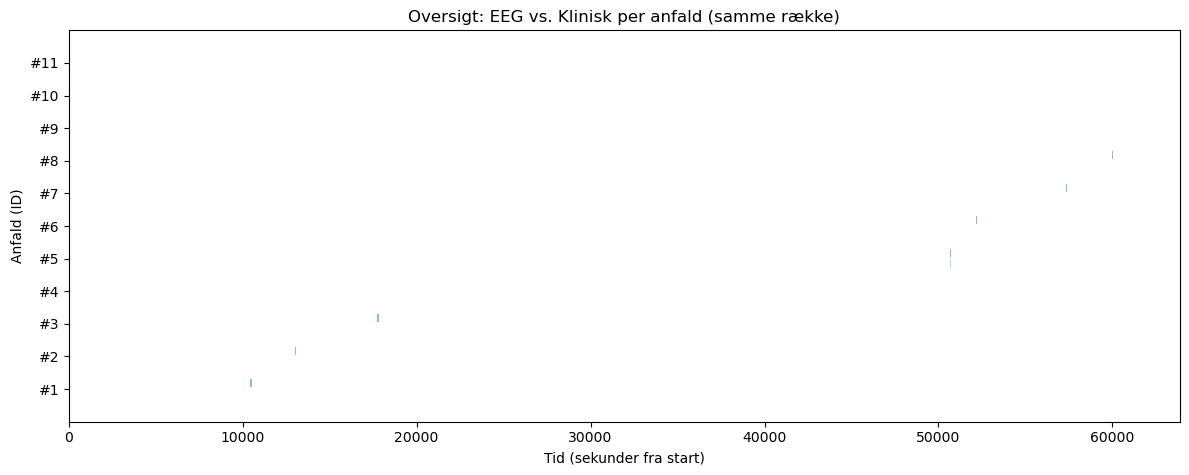

Antal anfald: 11
    seizure_id        date      eeg_onset_time     eeg_offset_time  \
0            1  03.05-2016 2016-05-03 14:12:34 2016-05-03 14:13:09   
1            2  03.05-2016 2016-05-03 14:56:26 2016-05-03 14:57:03   
2            3  03.05-2016 2016-05-03 16:15:01 2016-05-03 16:15:29   
3            4  03.05-2016 2016-05-03 22:48:48 2016-05-03 22:49:02   
4            5  04.05-2016 2016-05-04 01:23:32 2016-05-04 01:23:57   
5            6  04.05-2016 2016-05-04 01:48:52 2016-05-04 01:49:11   
6            7  04.05-2016                 NaT                 NaT   
7            8  04.05-2016                 NaT                 NaT   
8            9  04.05-2016 2016-05-04 05:26:30 2016-05-04 05:26:51   
9           10  04.05-2016                 NaT                 NaT   
10          11  04.05-2016                 NaT                 NaT   

       klin_onset_time    klin_offset_time         seizure_type  \
0  2016-05-03 14:12:27 2016-05-03 14:14:12  frontale, temporale   
1  2016-

In [5]:
from ekg_tdms_pipeline_v5_fix import (
    load_tdms,
    read_annotations_structured, structured_to_long,
    align_structured_to_samples, plot_overview_structured,
    count_seizures
)

ann_struct = read_annotations_structured(ann_path, header=6)
sig, meta = load_tdms(tdms_path)
print(meta.start_time)

# <- denne er nu kompatibel med din pandas
ann_aligned = align_structured_to_samples(ann_struct, meta)

plot_overview_structured(meta, ann_aligned)
print("Antal anfald:", count_seizures(ann_struct))

print(ann_struct)

In [ ]:
# Test kode til at tilføje ekstra anfald i tilfælde af fejl i annoteringsfilen
new_seizure = {
    "seizure_id": 2,
    "date": "28.11.17",
    "eeg_onset_time": pd.Timestamp("2017-11-28 15:33:08"),
    "eeg_offset_time": pd.Timestamp("2017-11-28 15:44:59"),
    "klin_onset_time": pd.Timestamp("2017-11-28 15:33:10"),
    "klin_offset_time": pd.Timestamp("2017-11-28 15:44:59"),
    "seizure_type": "Complex partial",
}

# Append the new seizure to the 'ann' DataFrame
ann_struct = pd.concat([ann_struct, pd.DataFrame([new_seizure])], ignore_index=True)

# Print the updated DataFrame
print(ann_struct)

   seizure_id      date      eeg_onset_time     eeg_offset_time  \
0           1  29.11.17 2017-11-29 15:33:08 2017-11-29 15:44:59   
1           2  28.11.17 2017-11-28 15:33:08 2017-11-28 15:44:59   

      klin_onset_time    klin_offset_time      seizure_type  notes  
0 2017-11-29 15:33:10 2017-11-29 15:44:59  kompleks partiel    NaN  
1 2017-11-28 15:33:10 2017-11-28 15:44:59   Complex partial    NaN  


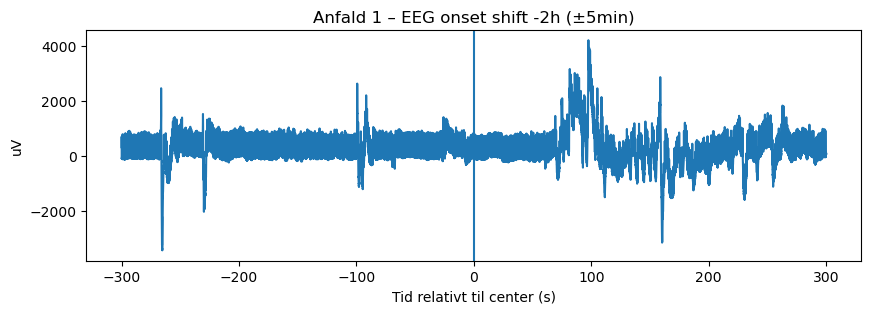

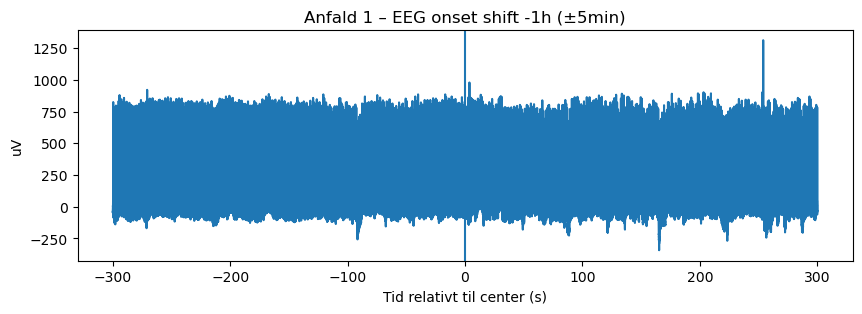

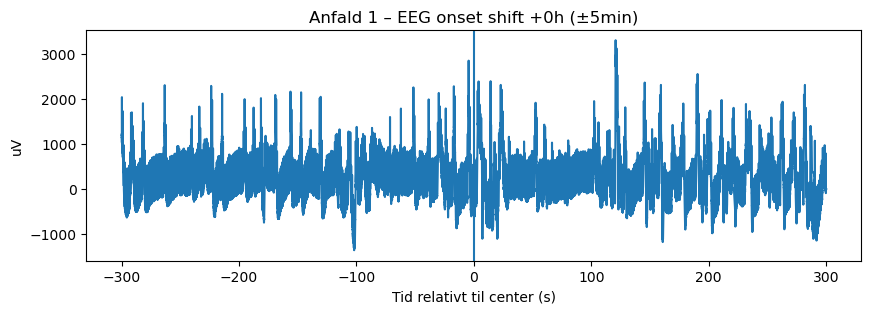

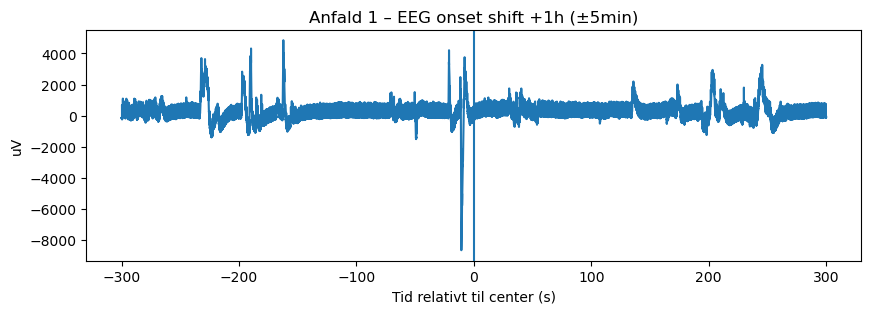

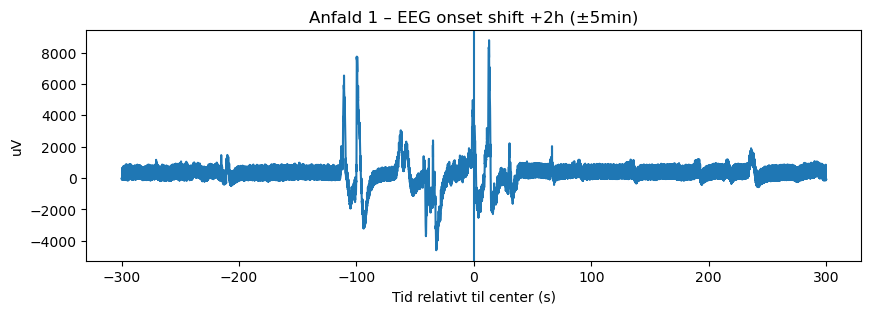

   seizure_id      date            eeg_onset_time           eeg_offset_time  \
0           1  12.09.16 2016-09-12 15:46:01+02:00 2016-09-12 15:46:52+02:00   

            klin_onset_time          klin_offset_time      seizure_type  \
0 2016-09-12 15:45:57+02:00 2016-09-12 15:47:34+02:00  kompleks partiel   

               notes  eeg_onset_idx  eeg_offset_idx  klin_onset_idx  \
0  pt.bliver tiltalt        9093632         9119744         9091584   

   klin_offset_idx  
0          9141248  
RecordingMeta(fs=512.0, start_time=Timestamp('2016-09-12 10:50:00+0200', tz='Europe/Copenhagen'), n_samples=29145601, channel_name='EKG', units='uV', path='E:\\ML algoritme tl anfaldsdetektion vha HRV\\ePatch data from Aarhus to Lausanne\\Patients ePatch data\\Patient 4\\recording 1\\Patient 4_1.tdms')


In [155]:
from ekg_tdms_pipeline_v5_fix import read_annotations_structured, align_structured_to_samples, load_tdms
from seizure_window_analysis import analyze_shifted_windows

# Indlæs det strukturerede ark og TDMS (som du allerede gør)
# ann_struct = read_annotations_structured(ann_path, header=6)
sig, meta = load_tdms(tdms_path)
ann_aligned = align_structured_to_samples(ann_struct, meta)

# Kør analyse: ±5 min vindue, flyttet -2h, -1h, 0h, +1h, +2h ift. onset
df = analyze_shifted_windows(
    sig, meta, ann_aligned,
    use="eeg_onset_idx",         # eller "klin_onset_idx"
    half_window_sec=300,         # ±5 min
    shifts_sec=[-7200,-3600,0,3600,7200],
    plot=True                    # sæt False hvis du kun vil have tal
)

# Se resultat-tabellen
df.head()

print(ann_aligned)
print(meta)


In [108]:
output_path = "df_results.csv"  # Specify the desired file path
df.to_csv(output_path, index=False)
print(f"DataFrame saved to {output_path}")

DataFrame saved to df_results.csv


In [6]:
from nptdms import TdmsFile

def debug_tdms_properties(path):
    tf = TdmsFile.read(path)
    print("=== File properties ===")
    for k, v in tf.properties.items():
        print(f"{k}: {v!r}")

    for g in tf.groups():
        print(f"\n=== Group: {g.name} properties ===")
        for k, v in g.properties.items():
            print(f"{k}: {v!r}")

        for ch in g.channels():
            print(f"\n  --- Channel: {ch.name} properties ---")
            for k, v in ch.properties.items():
                print(f"  {k}: {v!r}")

# Brug:
debug_tdms_properties(tdms_path)


=== File properties ===
name: 'Alexander Bloch Karup_ 03_05_2016_kl_131905__04_05_2016_kl_0800.tdms'
author: 'Jesper'
description: ''
registertxt1: 'Written by National Instruments LabVIEW'

=== Group: Untitled properties ===
wf_xcolumns: 'None'

  --- Channel: EKG properties ---
  wf_start_time: numpy.datetime64('2016-05-03T11:19:05.000000')
  wf_start_offset: 0.0
  wf_increment: 0.001953125
  wf_samples: 32708992
  DigitalMaximum: 32767
  DigitalMinimum: -32768
  NI_ChannelName: 'EKG'
  NI_ExpIsRelativeTime: False
  wf_time_pref: 'absolute'
  NI_ExpStartTimeStamp: numpy.datetime64('2016-05-03T11:19:05.000000')
  NI_ExpTimeStamp: numpy.datetime64('2016-05-03T11:19:05.000000')
  NI_ExpXDimension: 't'
  wf_xname: 'Time'
  wf_xunit_string: 's'
  NI_UnitDescription: 'uV'
  unit_string: 'uV'
  PhysicalMaximum: 90298.0
  PhysicalMinimum: -90298.0
  PreFilter: ''
  TransducerType: ''
  ValsPerRec: 128


In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_seizure_startstop_window(sig, meta, ann_aligned,
                                  seizure_id=None,
                                  source_preference=("eeg", "klin"),
                                  pre_sec=30, post_sec=30,
                                  shift_sec=0):
    """
    Plot for hvert anfald et vindue fra -pre_sec før start til +post_sec efter stop.
    - x-akse har 0s ved anfaldsstart (onset); venstre kant er -pre_sec.
    - Området mellem start og stop skygge-markeres.
    - shift_sec kan bruges til at teste tidsforskydning (fx 3600 for +1 time).

    Parameters
    ----------
    sig : np.ndarray
    meta : RecordingMeta (fra ekg_tdms_pipeline_v5_fix)
    ann_aligned : DataFrame med kolonner: eeg_onset_idx/offset_idx, klin_onset_idx/offset_idx, seizure_id
    seizure_id : int eller None (None = plot alle)
    source_preference : tuple prioritet mellem ("eeg","klin")
    pre_sec, post_sec : marginer i sekunder før/efter
    shift_sec : påført forskydning (i sek) på både start og stop (til TZ-test)

    Returns
    -------
    None (viser plots)
    """
    fs = meta.fs
    n = meta.n_samples

    # vælg rækker
    if seizure_id is not None:
        rows = ann_aligned[ann_aligned["seizure_id"] == seizure_id]
    else:
        rows = ann_aligned

    if rows.empty:
        print("Ingen anfald fundet i de angivne kriterier.")
        return

    def pick_indices(r):
        for pref in source_preference:
            if pref == "eeg":
                on, off = r.get("eeg_onset_idx"), r.get("eeg_offset_idx")
            else:
                on, off = r.get("klin_onset_idx"), r.get("klin_offset_idx")
            if pd.notna(on) and pd.notna(off):
                return int(on), int(off), pref.upper()
        # fallback: hvis kun onset findes, syntetiser kort varighed (30s)
        for pref in source_preference:
            on = r.get(f"{pref}_onset_idx")
            if pd.notna(on):
                return int(on), int(on) + int(30*fs), pref.upper()
        return None, None, None

    for _, r in rows.iterrows():
        onset_idx, offset_idx, label = pick_indices(r)
        if onset_idx is None:
            continue

        # anvend evt. tidsforskydning til test
        onset_idx  = int(np.clip(onset_idx  + int(shift_sec*fs), 0, n-1))
        offset_idx = int(np.clip(offset_idx + int(shift_sec*fs), 1, n))

        # beregn vinduesgrænser
        i0 = max(0, onset_idx - int(pre_sec*fs))
        i1 = min(n,  offset_idx + int(post_sec*fs))

        segment = sig[i0:i1]
        # tid relativt til onset:
        t = (np.arange(i0, i1) - onset_idx) / fs

        # hvor ligger stop relativt til onset?
        stop_rel_sec = (offset_idx - onset_idx) / fs

        # plot
        fig, ax = plt.subplots(figsize=(12, 3))
        ax.plot(t, segment)                # ingen farver styles sættes
        ax.axvline(0.0)                    # markér onset
        ax.axvspan(0.0, stop_rel_sec, alpha=0.2)  # skygge mellem start→stop
        ax.set_xlim(-pre_sec, (i1 - onset_idx)/fs)  # enden kan være > post_sec, afhængig af stop
        ax.set_xlabel("Tid relativt til anfaldsstart (s)")
        ax.set_ylabel(meta.units or "Amplitude")
        sid = r.get("seizure_id", "?")
        ax.set_title(f"Anfald {sid} – {label}  (vindue: -{pre_sec}s → +{post_sec}s fra stop)")
        plt.show()


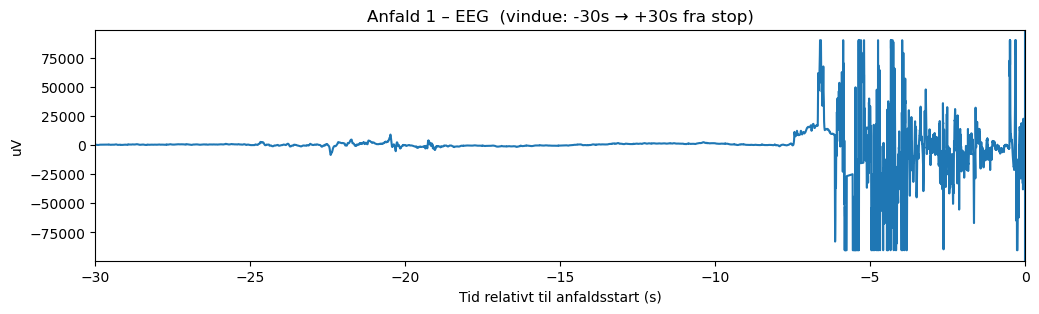

In [111]:
# typisk: brug de sampleindekser vi allerede har beregnet:
plot_seizure_startstop_window(sig, meta, ann_aligned,
                              seizure_id=1,            # eller None for alle
                              source_preference=("eeg","klin"),
                              pre_sec=30, post_sec=30,
                              shift_sec=0)             # sæt fx 3600 eller -3600 for TZ-test


Shift -2h


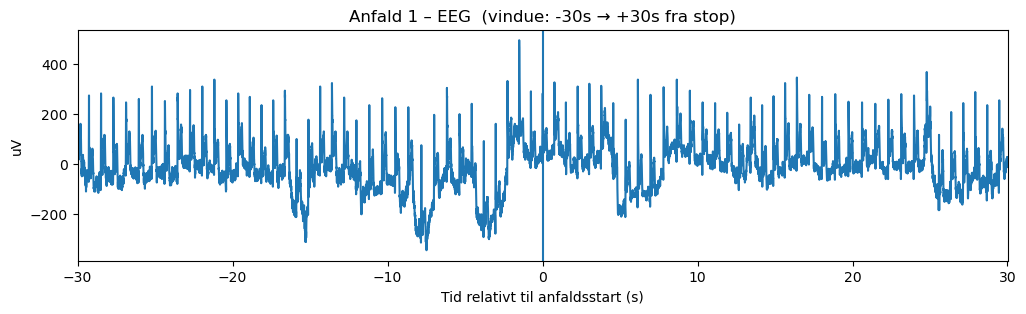

Shift -1h


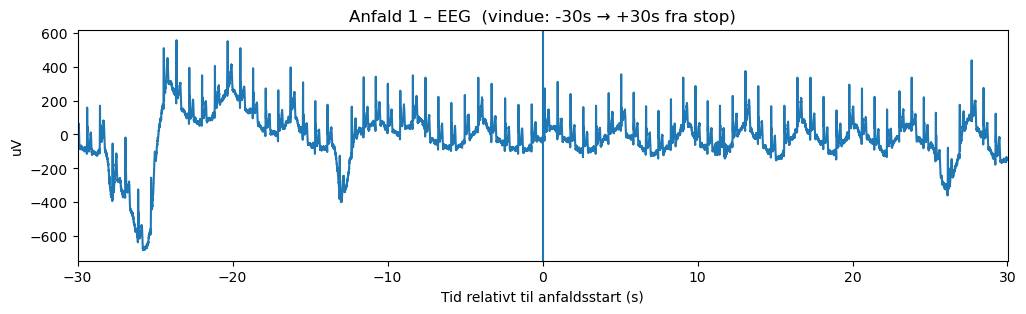

Shift +0h


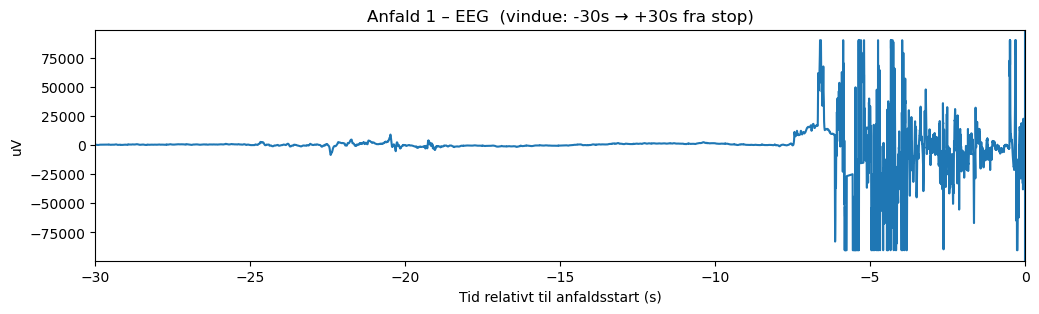

Shift +1h


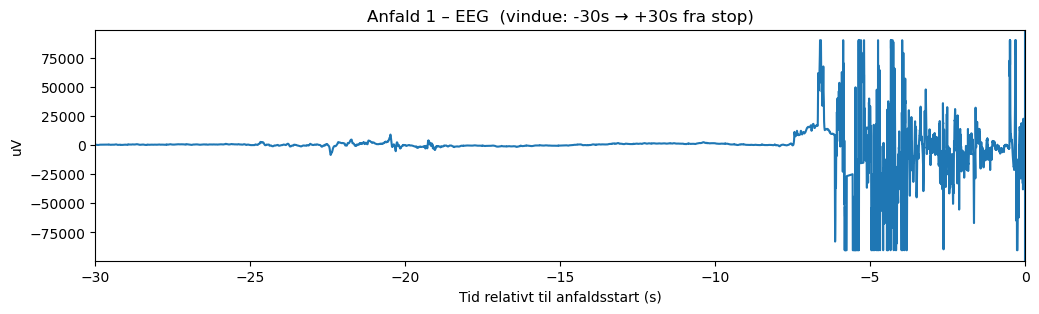

Shift +2h


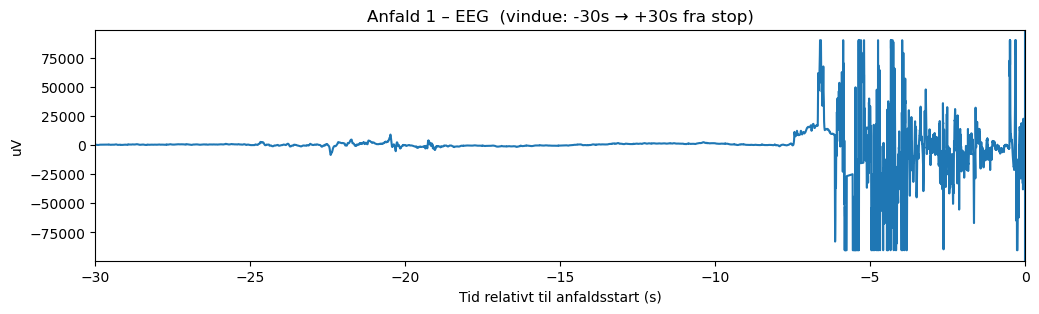

In [112]:
for s in (-7200, -3600, 0, 3600, 7200):
    print(f"Shift {s//3600:+}h")
    plot_seizure_startstop_window(sig, meta, ann_aligned, seizure_id=1, shift_sec=s)


In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_seizure_with_shifts(sig, meta, ann_aligned,
                             seizure_id=1,
                             source_preference=("eeg","klin"),
                             pre_sec=30, post_sec=30,
                             shifts_sec=(-7200,-3600,0,3600,7200)):
    """
    Plot ét anfald i 5 subplots (fast grid), med forskellige tidsforskydninger.
    Alle subplots deler samme y-akse-skala for direkte visuel sammenligning.
    """

    fs, n = meta.fs, meta.n_samples
    row = ann_aligned[ann_aligned["seizure_id"] == seizure_id].iloc[0]

    def pick_indices(r):
        for pref in source_preference:
            if pref == "eeg":
                on, off = r.get("eeg_onset_idx"), r.get("eeg_offset_idx")
            else:
                on, off = r.get("klin_onset_idx"), r.get("klin_offset_idx")
            if pd.notna(on) and pd.notna(off):
                return int(on), int(off), pref.upper()
        for pref in source_preference:  # fallback hvis kun onset
            on = r.get(f"{pref}_onset_idx")
            if pd.notna(on):
                return int(on), int(on)+int(30*fs), pref.upper()
        return None, None, None

    onset_idx, offset_idx, label = pick_indices(row)
    if onset_idx is None:
        print("Ingen gyldige onset/offset fundet.")
        return

    # Først udtræk alle vinduer for at finde global min/max
    all_segments = []
    for shift in shifts_sec:
        onset_s = int(np.clip(onset_idx + shift*fs, 0, n-1))
        offset_s = int(np.clip(offset_idx + shift*fs, 1, n))
        i0 = max(0, onset_s - int(pre_sec*fs))
        i1 = min(n, offset_s + int(post_sec*fs))
        seg = sig[i0:i1]
        all_segments.append(seg)

    global_min = min(np.min(s) for s in all_segments)
    global_max = max(np.max(s) for s in all_segments)

    # Nu plot alle med samme ylim
    fig, axes = plt.subplots(len(shifts_sec), 1, figsize=(12, 2.5*len(shifts_sec)), sharex=True, sharey=True)

    for ax, shift, seg in zip(axes, shifts_sec, all_segments):
        onset_s = int(np.clip(onset_idx + shift*fs, 0, n-1))
        offset_s = int(np.clip(offset_idx + shift*fs, 1, n))
        i0 = max(0, onset_s - int(pre_sec*fs))
        i1 = min(n, offset_s + int(post_sec*fs))
        t = (np.arange(i0,i1) - onset_s)/fs
        stop_rel_sec = (offset_s - onset_s)/fs

        ax.plot(t, seg)
        ax.axvline(0.0)
        ax.axvspan(0.0, stop_rel_sec, alpha=0.2)
        ax.set_xlim(-pre_sec, stop_rel_sec+post_sec)
        ax.set_ylim(global_min, global_max)
        ax.set_ylabel(meta.units or "Amp")
        shift_h = shift//3600
        ax.set_title(f"Seizure {seizure_id} – {label} onset shift {shift_h:+}h")

    axes[-1].set_xlabel("Time relative to seizure start (s)")
    fig.suptitle(f"Seizure {seizure_id} with shifted windows (shared y-axis, –{pre_sec}s → +{post_sec}s)", y=1.02)
    plt.tight_layout()
    plt.show()


In [135]:
print(ann_aligned)

   seizure_id      date            eeg_onset_time           eeg_offset_time  \
0           1  29.11.17 2017-11-29 15:33:08+01:00 2017-11-29 15:44:59+01:00   
1           2  28.11.17 2017-11-28 15:33:08+01:00 2017-11-28 15:44:59+01:00   

            klin_onset_time          klin_offset_time      seizure_type  \
0 2017-11-29 15:33:10+01:00 2017-11-29 15:44:59+01:00  kompleks partiel   
1 2017-11-28 15:33:10+01:00 2017-11-28 15:44:59+01:00   Complex partial   

   notes  eeg_onset_idx  eeg_offset_idx  klin_onset_idx  klin_offset_idx  
0    NaN       91739776        91739777        91739776         91739777  
1    NaN       52284928        52648960        52285952         52648960  


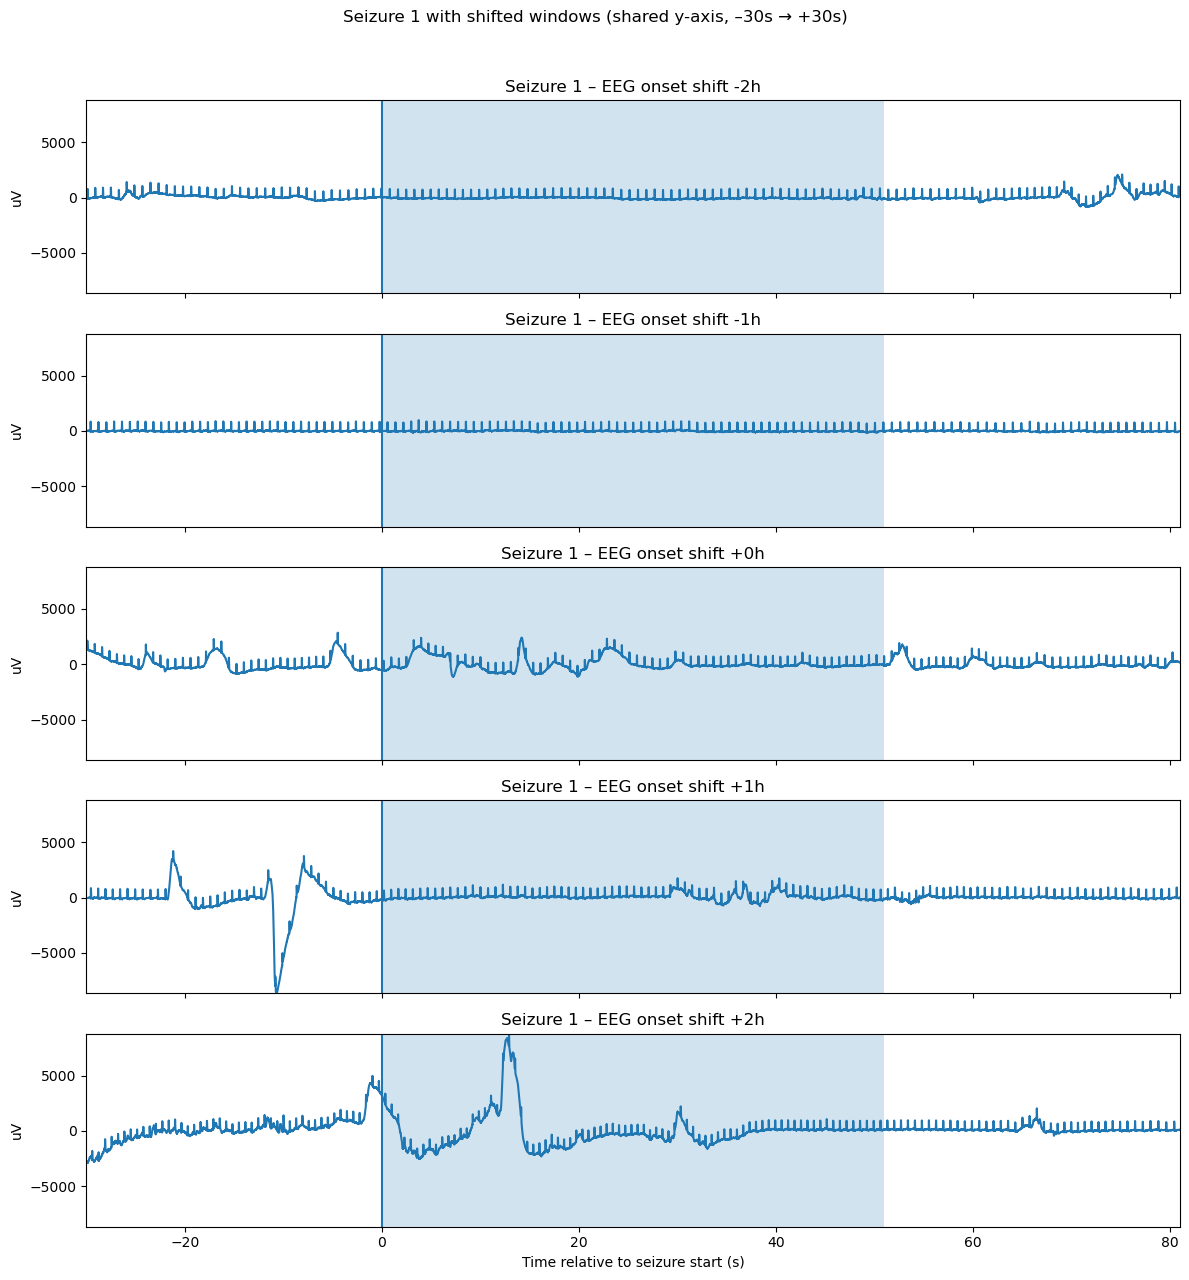

In [158]:
plot_seizure_with_shifts(sig, meta, ann_aligned,
                         seizure_id=1,
                         shifts_sec=(-7200,-3600,0,3600,7200))


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) R-peak detektion (simpel, robust) ---
from scipy.signal import butter, filtfilt, find_peaks

def bandpass(signal, fs, low=5.0, high=20.0, order=2):
    nyq = fs/2
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, signal)

def detect_r_peaks(ecg, fs, prom_factor=4.0, distance_ms=250):
    """
    Simpel R-top detektor:
      - let båndpas 5-20 Hz
      - absolutværdi + glatning
      - find_peaks med adaptiv prominence
    distance_ms: min. RR ~ 250 ms (240 bpm) som sikkerheds-maks
    """
    x = bandpass(ecg, fs)
    env = np.abs(x)
    # glat let (bevæg dig evt. op/ned afhængig af støjniveau)
    win = int(fs*0.1) or 1
    env_smooth = np.convolve(env, np.ones(win)/win, mode="same")
    prom = np.median(env_smooth) * prom_factor
    peaks, _ = find_peaks(env_smooth, prominence=prom, distance=int(fs*distance_ms/1000))
    return peaks

# --- 2) RR-serie og hjælpere ---
def rr_intervals_from_peaks(peaks, fs):
    """Returnerer (rr_s, rr_times_s) hvor rr_s er sekunder mellem på hinanden følgende R-toppe,
       og rr_times_s er tidstemplet for hver RR (midt mellem de to peaks)."""
    t_peaks = peaks / fs
    rr_s = np.diff(t_peaks)
    rr_times = t_peaks[:-1] + rr_s/2.0
    return rr_s, rr_times

def sd1_sd2_from_rr(rr_window):
    """
    Brug standardforhold:
      SDNN = std(RR)
      SDSD = std(diff(RR))
      SD1  = sqrt(0.5) * SDSD
      SD2  = sqrt(2*SDNN^2 - 0.5*SDSD^2)
    """
    if len(rr_window) < 3:
        return np.nan, np.nan
    sdnn = np.std(rr_window, ddof=0)
    sdsd = np.std(np.diff(rr_window), ddof=0) if len(rr_window) >= 2 else np.nan
    if np.isnan(sdnn) or np.isnan(sdsd):
        return np.nan, np.nan
    sd1 = np.sqrt(0.5) * sdsd
    val = 2*(sdnn**2) - 0.5*(sdsd**2)
    sd2 = np.sqrt(val) if val > 0 else np.nan
    return sd1, sd2

# --- 3) CSI/ModCSI i glidende RR-vinduer ---
def rolling_csi_modcsi(rr_s, rr_times_s, k=100, step=1):
    """
    rr_s: RR i sek.
    rr_times_s: tid for hvert RR (sek fra optagelsesstart)
    Returnerer DataFrame med tid (sek), SD1, SD2, CSI, ModCSI.
    """
    idx = []
    SD1 = []
    SD2 = []
    CSI = []
    MCSI = []
    n = len(rr_s)
    for i in range(0, n - k + 1, step):
        win = rr_s[i:i+k]
        sd1, sd2 = sd1_sd2_from_rr(win)
        if np.isnan(sd1) or np.isnan(sd2) or sd1 == 0:
            csi = np.nan; mcsi = np.nan
        else:
            csi = sd2 / sd1                     # = L/T
            mcsi = 4.0 * (sd2**2) / sd1         # = (L^2)/T  med L=4*SD2, T=4*SD1
        SD1.append(sd1); SD2.append(sd2); CSI.append(csi); MCSI.append(mcsi)
        # tid -> sæt ved vinduets center (eller slut): vi bruger center
        center_t = np.mean(rr_times_s[i:i+k])
        idx.append(center_t)
    df = pd.DataFrame({
        "t_sec": np.array(idx),
        "SD1": np.array(SD1),
        "SD2": np.array(SD2),
        "CSI": np.array(CSI),
        "ModCSI": np.array(MCSI),
    })
    return df

# --- 4) Overlejring med anfald + enkel tærskelklassifikation ---
def detect_from_baseline(series, baseline_quantile=0.8, gain=2.0, min_duration_s=5.0, time=None):
    """
    Meget enkel detektion: baseline = quantil (fx 80%) af serien før første anfald (eller hele serien),
    tærskel = baseline * gain. Returnerer boolean maske + tærskel.
    """
    x = np.asarray(series, float)
    if time is None:
        time = np.arange(len(x), dtype=float)
    # baseline: brug hele signalet hvis du ikke vil “kigge frem”
    base = np.nanquantile(x[~np.isnan(x)], baseline_quantile)
    thr = base * gain
    above = x > thr
    # fjern meget korte “hits”
    if len(time) == len(x):
        dt = np.diff(time, prepend=time[0])
        # kumulativ varighed i løbende run
        keep = above.copy()
        run_start = None
        acc = 0.0
        for i, flag in enumerate(above):
            if flag:
                if run_start is None:
                    run_start = i
                    acc = 0.0
                acc += dt[i]
            else:
                if run_start is not None and acc < min_duration_s:
                    keep[run_start:i] = False
                run_start = None
        # sidste run
        if run_start is not None and acc < min_duration_s:
            keep[run_start:] = False
        above = keep
    return above, thr

def plot_csi_with_seizures(csi_df, meta, ann_aligned, which="ModCSI", seizure_id=None, source=("eeg","klin"),
                           baseline_q=0.8, gain=2.0, min_dur_s=5.0):
    """
    Plot CSI/ModCSI over tid (sek fra start), overlejret med anfaldsskygger.
    Laver også simpel tærskellinje + detektionsmarkering.
    """
    y = csi_df[which].values
    t = csi_df["t_sec"].values
    det_mask, thr = detect_from_baseline(y, baseline_q, gain, min_dur_s, t)

    # lav figur
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(t, y, label=which)
    ax.axhline(thr, linestyle="--", label=f"threshold ({gain}× q{int(baseline_q*100)})")
    # marker detekterede områder
    ax.fill_between(t, 0, y, where=det_mask, alpha=0.2, label="detected")

    # overlejrer anfaldsperioder
    rows = ann_aligned if seizure_id is None else ann_aligned[ann_aligned["seizure_id"]==seizure_id]
    for _, r in rows.iterrows():
        # vælg kilde
        on=off=None
        for p in source:
            on_i, off_i = r.get(f"{p}_onset_idx"), r.get(f"{p}_offset_idx")
            if pd.notna(on_i) and pd.notna(off_i):
                on, off = int(on_i)/meta.fs, int(off_i)/meta.fs
                break
        if on is None:
            continue
        ax.axvspan(on, off, alpha=0.15)

    ax.set_xlabel("Tid fra optagelsesstart (s)")
    ax.set_ylabel(which)
    ax.set_title(f"{which} over tid (+ anfaldsskygger)")
    ax.legend()
    plt.tight_layout()
    plt.show()


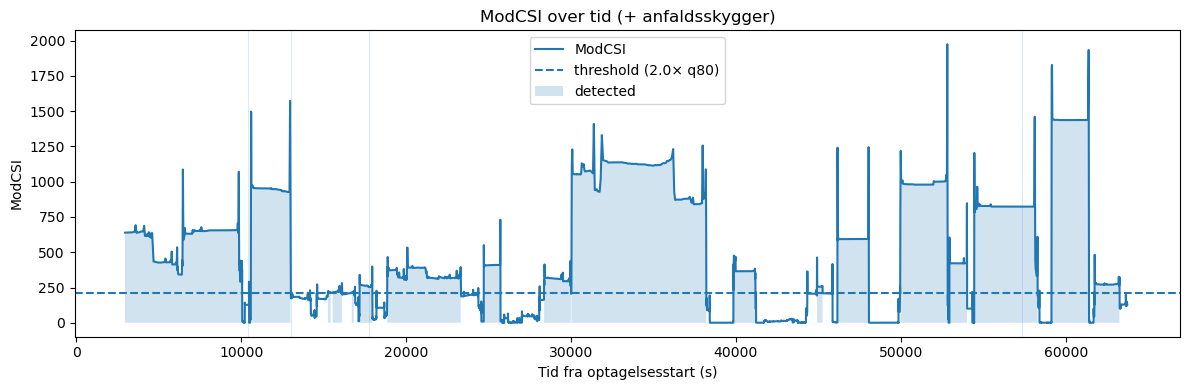

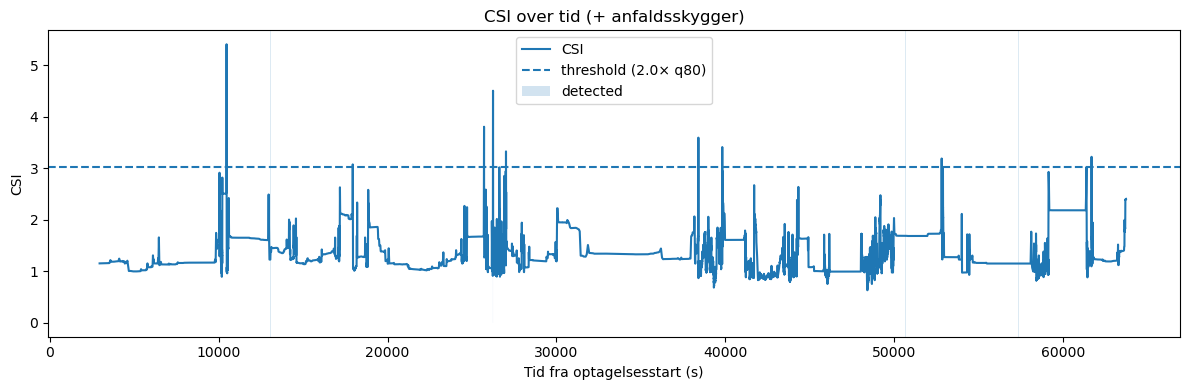

In [8]:
# 1) R-toppe og RR
r_peaks = detect_r_peaks(sig, meta.fs)       # brug evt. dine egne R-toppe hvis du har dem
rr_s, rr_t = rr_intervals_from_peaks(r_peaks, meta.fs)

# 2) CSI/ModCSI i glidende vindue (k=100 som i Jeppesen m.fl.)
hrv_df = rolling_csi_modcsi(rr_s, rr_t, k=100, step=1)

# 3) Plot ModCSI og anfald
plot_csi_with_seizures(hrv_df, meta, ann_aligned, which="ModCSI",
                       baseline_q=0.8, gain=2.0, min_dur_s=5.0)

# (Du kan også kigge på CSI)
plot_csi_with_seizures(hrv_df, meta, ann_aligned, which="CSI",
                       baseline_q=0.8, gain=2.0, min_dur_s=5.0)


In [9]:
print(r_peaks.shape)
print(rr_s.shape)
print(rr_t.shape)

(12329,)
(12328,)
(12328,)


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# --- R-peak detection (simpel robust) ---
def _bandpass(signal, fs, low=5.0, high=20.0, order=2):
    nyq = fs/2
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, signal)

def detect_r_peaks(ecg, fs, prom_factor=4.0, distance_ms=250):
    x = _bandpass(ecg, fs)
    env = np.abs(x)
    win = int(fs*0.1) or 1
    env_smooth = np.convolve(env, np.ones(win)/win, mode="same")
    prom = np.median(env_smooth) * prom_factor
    peaks, _ = find_peaks(env_smooth, prominence=prom, distance=int(fs*distance_ms/1000))
    return peaks

# --- RR + SD1/SD2 + CSI/ModCSI ---
def rr_intervals_from_peaks(peaks, fs):
    t_peaks = peaks / fs
    rr_s = np.diff(t_peaks)
    rr_times = t_peaks[:-1] + rr_s/2.0
    return rr_s, rr_times

def _sd1_sd2(rr_window):
    if len(rr_window) < 3:
        return np.nan, np.nan
    sdnn = np.std(rr_window, ddof=0)
    sdsd = np.std(np.diff(rr_window), ddof=0) if len(rr_window) >= 2 else np.nan
    if np.isnan(sdnn) or np.isnan(sdsd):
        return np.nan, np.nan
    sd1 = np.sqrt(0.5) * sdsd
    val = 2*(sdnn**2) - 0.5*(sdsd**2)
    sd2 = np.sqrt(val) if val > 0 else np.nan
    return sd1, sd2

def rolling_csi_modcsi(rr_s, rr_times_s, k=100, step=1):
    idx=[]; SD1=[]; SD2=[]; CSI=[]; MCSI=[]
    n=len(rr_s)
    for i in range(0, n-k+1, step):
        win = rr_s[i:i+k]
        sd1, sd2 = _sd1_sd2(win)
        if np.isnan(sd1) or np.isnan(sd2) or sd1 == 0:
            csi = np.nan; mcsi = np.nan
        else:
            csi  = sd2 / sd1
            mcsi = 4.0 * (sd2**2) / sd1  # ModCSI
        SD1.append(sd1); SD2.append(sd2); CSI.append(csi); MCSI.append(mcsi)
        idx.append(np.mean(rr_times_s[i:i+k]))
    return pd.DataFrame({"t_sec": np.array(idx), "SD1": SD1, "SD2": SD2, "CSI": CSI, "ModCSI": MCSI})

def _detect_from_baseline(series, baseline_quantile=0.8, gain=2.0, min_duration_s=5.0, time=None):
    x = np.asarray(series, float)
    if time is None:
        time = np.arange(len(x), dtype=float)
    valid = ~np.isnan(x)
    base = np.nanquantile(x[valid], baseline_quantile) if valid.any() else np.nan
    thr = base * gain if np.isfinite(base) else np.nan
    above = (x > thr) & np.isfinite(x) & np.isfinite(thr)
    # fjern korte events
    keep = above.copy()
    if len(time) == len(x):
        dt = np.diff(time, prepend=time[0])
        run_start=None; acc=0.0
        for i, flag in enumerate(above):
            if flag:
                if run_start is None:
                    run_start=i; acc=0.0
                acc += dt[i]
            else:
                if run_start is not None and acc < min_duration_s:
                    keep[run_start:i] = False
                run_start=None
        if run_start is not None and acc < min_duration_s:
            keep[run_start:] = False
    return keep, thr


In [145]:
# fra dit eksisterende sig/meta
r_peaks = detect_r_peaks(sig, meta.fs)
rr_s, rr_t = rr_intervals_from_peaks(r_peaks, meta.fs)
hrv_df = rolling_csi_modcsi(rr_s, rr_t, k=100, step=1)  # k=100 som i Jeppesen m.fl.


In [12]:
def plot_seizure_with_shifts_and_csi(sig, meta, ann_aligned, hrv_df,
                                     seizure_id=None,
                                     source_preference=("eeg","klin"),
                                     pre_sec=30, post_sec=30,
                                     shifts_sec=(-7200,-3600,0,3600,7200),
                                     which="ModCSI",
                                     baseline_q=0.8, gain=2.0, min_dur_s=5.0):
    """
    Én figur med 5 subplots: signal + CSI/ModCSI (sekundær y-akse) for de valgte shifts.
    """
    fs, n = meta.fs, meta.n_samples

    # vælg anfaldsrække
    if seizure_id is None:
        if ann_aligned.empty:
            print("ann_aligned er tom.")
            return
        row = ann_aligned.iloc[0]
        sid = row.get("seizure_id", 1)
    else:
        sub = ann_aligned[ann_aligned["seizure_id"]==seizure_id]
        if sub.empty:
            avail = ann_aligned["seizure_id"].dropna().unique().tolist()
            print(f"Seizure {seizure_id} findes ikke. Tilgængelige: {avail}")
            return
        row = sub.iloc[0]; sid = seizure_id

    # vælg onset/offset (prioriter EEG → Klinisk el. som angivet)
    def pick_indices(r):
        for pref in source_preference:
            on = r.get(f"{pref}_onset_idx"); off = r.get(f"{pref}_offset_idx")
            if pd.notna(on) and pd.notna(off):
                return int(on), int(off), pref.upper()
        for pref in source_preference:
            on = r.get(f"{pref}_onset_idx")
            if pd.notna(on):
                return int(on), int(on)+int(30*fs), pref.upper()
        return None, None, None

    onset_idx, offset_idx, label = pick_indices(row)
    if onset_idx is None:
        print(f"Anfald {sid} mangler onset/offset.")
        return

    # For fælles y-akse på signalet: saml alle segmenter først
    segs = []; t_axes = []; rel_stops = []; idx_pairs = []
    for shift in shifts_sec:
        on_s  = int(np.clip(onset_idx  + int(shift*fs), 0, n-1))
        off_s = int(np.clip(offset_idx + int(shift*fs), 1, n))
        i0 = max(0, on_s - int(pre_sec*fs))
        i1 = min(n,  off_s + int(post_sec*fs))
        seg = sig[i0:i1]
        t_rel = (np.arange(i0, i1) - on_s)/fs
        segs.append(seg); t_axes.append(t_rel); rel_stops.append((off_s - on_s)/fs)
        idx_pairs.append((i0, i1, on_s, off_s))

    valid = [s for s in segs if s.size>0]
    if not valid:
        print("Vinduerne er tomme ift. signalets længde.")
        return
    gmin = min(np.min(s) for s in valid)
    gmax = max(np.max(s) for s in valid)
    if np.isclose(gmin, gmax):
        pad = 1.0 if gmin == 0 else abs(gmin)*0.05
        gmin, gmax = gmin - pad, gmax + pad

    # Forbered CSI/ModCSI baseline + threshold én gang (på hele serien)
    y_all = hrv_df[which].values
    t_all = hrv_df["t_sec"].values
    det_mask_all, thr = _detect_from_baseline(y_all, baseline_q, gain, min_dur_s, t_all)

    fig, axes = plt.subplots(len(shifts_sec), 1, figsize=(12, 2.6*len(shifts_sec)), sharex=False, sharey=True)

    for ax, shift, seg, t_rel, stop_rel, pair in zip(axes, shifts_sec, segs, t_axes, rel_stops, idx_pairs):
        i0, i1, on_s, off_s = pair
        # signal
        ax.plot(t_rel, seg)
        ax.axvline(0.0)
        ax.axvspan(0.0, stop_rel, alpha=0.2)
        ax.set_xlim(-pre_sec, stop_rel + post_sec)
        ax.set_ylim(gmin, gmax)
        ax.set_ylabel(meta.units or "Amp")
        ax.set_title(f"Anfald {sid} – {label} onset shift {shift//3600:+}h")

        # CSI/ModCSI på sekundær akse i samme subplot
        ax2 = ax.twinx()
        # udtræk HRV i samme tidsvindue (absolut sekunder)
        t_abs0 = i0 / fs
        t_abs1 = i1 / fs
        m = (hrv_df["t_sec"] >= t_abs0) & (hrv_df["t_sec"] <= t_abs1)
        t_csi = hrv_df.loc[m, "t_sec"].values
        y_csi = hrv_df.loc[m, which].values
        # relativ tid ift. shifted onset
        t_csi_rel = t_csi - (on_s/fs)

        ax2.plot(t_csi_rel, y_csi)
        # tærskel
        ax2.axhline(thr, linestyle="--")
        # detektions-markering kun for segmentets udsnit
        m2 = (t_all >= t_abs0) & (t_all <= t_abs1)
        ax2.fill_between(t_all[m2] - (on_s/fs), 0, y_all[m2], where=det_mask_all[m2], alpha=0.15)
        ax2.set_ylabel(which)

    axes[-1].set_xlabel("Tid relativt til anfaldsstart (s)")
    fig.suptitle(f"Seizure {sid}: signal + {which} for shifts (fælles y-akse for signal)", y=1.02)
    plt.tight_layout()
    plt.show()


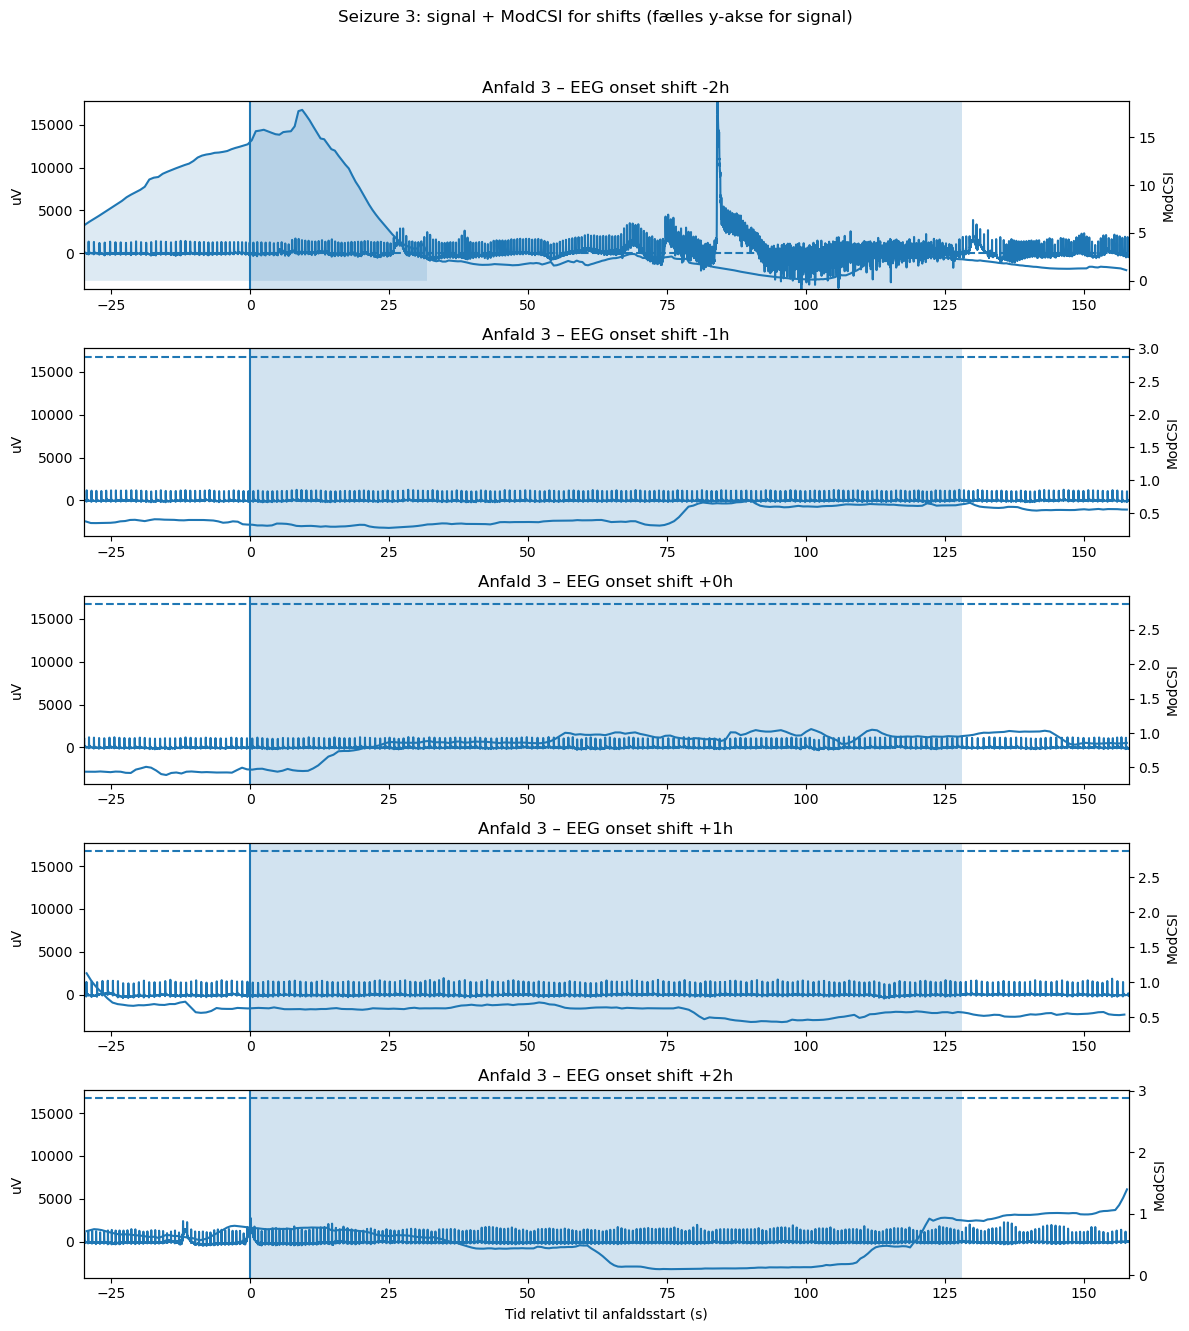

In [16]:
# 1) (allerede gjort): ann_aligned = align_structured_to_samples(...)

# 2) Forbered HRV én gang:
r_peaks = detect_r_peaks(sig, meta.fs)
rr_s, rr_t = rr_intervals_from_peaks(r_peaks, meta.fs)
hrv_df = rolling_csi_modcsi(rr_s, rr_t, k=100)

# 3) Plot – ModCSI er ofte tydeligst
plot_seizure_with_shifts_and_csi(
    sig, meta, ann_aligned, hrv_df,
    seizure_id=3,                       # eller None for første anfald
    source_preference=("eeg","klin"),
    pre_sec=30, post_sec=30,
    shifts_sec=(-7200,-3600,0,3600,7200),
    which="ModCSI",                     # eller "CSI"
    baseline_q=0.8, gain=2.0, min_dur_s=5.0
)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft, butter, filtfilt, find_peaks

# ---------- Hjælpere ----------
def bandpass(x, fs, low=5.0, high=40.0, order=2):
    nyq = fs/2
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, x)

def modulation_spectrum(ecg, fs, win_sec=8.0, hop_sec=0.5, nperseg=None, noverlap=None):
    """
    Modulationsspektrum: |FFT_t( |STFT(ecg)| )|^2
    1) STFT -> spektrogram magnitude S(f, t)
    2) FFT langs tid -> modulation over tid pr. frekvensbin
    3) Summer over f -> M(fm), 'temporal modulation power'
    Returnerer fm (Hz), M_total (1D), og evt. S, tidsakse.
    """
    x = bandpass(ecg, fs)
    if nperseg is None:
        nperseg = int(win_sec*fs)  # fx 8s-vindue
    if noverlap is None:
        noverlap = int((win_sec - hop_sec)*fs)
    f, t, Z = stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap, window='hann', padded=False, boundary=None)
    S = np.abs(Z)  # [freq x time]

    # modulation: FFT over tid (akse=1)
    # NB: vi bruger real-FFT over tidsaksen for hver frekvensbin og summerer over f
    M = np.fft.rfft(S, axis=1)  # [freq x f_mod_bins]
    Mpow = (np.abs(M)**2).sum(axis=0)  # sum over frekvens
    fm = np.fft.rfftfreq(S.shape[1], d=(t[1]-t[0])) if len(t) > 1 else np.array([0.0])
    return fm, Mpow, (f, t, S)

def estimate_hr_from_rr(peaks, fs):
    if len(peaks) < 2:
        return np.nan
    rr = np.diff(peaks)/fs
    med_rr = np.median(rr)
    return 60.0/med_rr if med_rr > 0 else np.nan

def detect_r_peaks(ecg, fs, prom_factor=4.0, distance_ms=250):
    # enkel, robust R-peak
    x = bandpass(ecg, fs)
    env = np.abs(x)
    win = int(fs*0.1) or 1
    env_smooth = np.convolve(env, np.ones(win)/win, mode="same")
    prom = np.median(env_smooth) * prom_factor
    peaks, _ = find_peaks(env_smooth, prominence=prom, distance=int(fs*distance_ms/1000))
    return peaks

# ---------- MS-QI ----------
def compute_msqi(ecg, fs, hr_hint_bpm=None, hr_band_hz=(0.5, 4.0), harmonic_bw=0.25, max_harmonics=4):
    """
    Praktisk MS-QI: andelen af modulation-power i bånd omkring pulsens modulation (fundamental ~ HR i Hz)
    + harmoniske, relativt til samlet modulation-power (excl. DC).
    """
    fm, Mpow, _ = modulation_spectrum(ecg, fs)
    if len(fm) < 2:
        return np.nan, (fm, Mpow)

    # estimer HR hvis ikke givet
    if hr_hint_bpm is None:
        peaks = detect_r_peaks(ecg, fs)
        hr_hint_bpm = estimate_hr_from_rr(peaks, fs)
    hr_hz = (hr_hint_bpm/60.0) if (hr_hint_bpm and np.isfinite(hr_hint_bpm)) else None

    # total power (ekskl. DC for robusthed)
    total = Mpow[1:].sum()

    if total <= 0:
        return np.nan, (fm, Mpow)

    # vælg bånd: enten omkring estimeret HR og harmoniske, eller bredt [0.5..4] Hz hvis HR ukendt
    mask = np.zeros_like(Mpow, dtype=bool)
    if hr_hz and 0.3 <= hr_hz <= 4.5:
        for k in range(1, max_harmonics+1):
            f0 = k*hr_hz
            mask |= (fm >= (f0 - harmonic_bw)) & (fm <= (f0 + harmonic_bw))
    else:
        f1, f2 = hr_band_hz
        mask |= (fm >= f1) & (fm <= f2)

    # ekskluder DC (fm=0)
    mask[0] = False
    num = Mpow[mask].sum()
    msqi = float(num/total) if total > 0 else np.nan
    return msqi, (fm, Mpow)

# ---------- PD-QI (praktisk variant til ekstrasystoler) ----------
def compute_pdqi(ecg, fs, local_win=15.0, outlier_z=2.5):
    """
    Praktisk PD-QI: 'peak distance quality' som regularitet i RR.
    1) Find R-toppe -> RR-serie (sek).
    2) Lokalt glidende median RR -> residualer og Z-score -> andel af 'uregelmæssige' RR.
    3) PD-QI defineres som andel uregelmæssige RR (jo højere -> flere PVC/ekstrasystoler).
    Denne variant matcher artikel-ideen (ekstrasystoler) uden at afhænge af intern definition.
    """
    peaks = detect_r_peaks(ecg, fs)
    if len(peaks) < 3:
        return np.nan, (np.array([]), np.array([]))
    rr = np.diff(peaks)/fs
    t_rr = (peaks[:-1] + np.diff(peaks)/2)/fs  # midtpunkt for hver RR

    # glidende lokal median
    half = int(local_win/np.median(rr)) if np.isfinite(np.median(rr)) and np.median(rr)>0 else 10
    half = max(5, min(half, 200))
    med = np.copy(rr)
    for i in range(len(rr)):
        a = max(0, i-half); b = min(len(rr), i+half+1)
        med[i] = np.median(rr[a:b])
    resid = rr - med
    # robust std (MAD*1.4826)
    mad = np.median(np.abs(resid - np.median(resid)))
    robstd = mad*1.4826 if mad>0 else np.std(resid) if len(resid)>1 else 0.0
    if robstd == 0:
        return 0.0, (t_rr, rr)
    z = np.abs(resid)/robstd
    frac_out = float((z > outlier_z).mean())
    pdqi = frac_out
    return pdqi, (t_rr, rr)


In [18]:
def summarize_msqi_pdqi_in_window(sig, fs, t0_sec, t1_sec):
    i0 = max(0, int(t0_sec*fs)); i1 = min(len(sig), int(t1_sec*fs))
    seg = sig[i0:i1]
    msqi, _ = compute_msqi(seg, fs)
    pdqi, _ = compute_pdqi(seg, fs)
    return msqi, pdqi

def plot_seizure_with_shifts_qi(sig, meta, ann_aligned, seizure_id=None,
                                source_preference=("eeg","klin"),
                                pre_sec=30, post_sec=30,
                                shifts_sec=(-7200,-3600,0,3600,7200),
                                show_qi=True):
    # === dette er din forrige plot-funktion med fælles y-akse, udvidet med MS-QI/PD-QI tekst ===
    fs, n = meta.fs, meta.n_samples

    # vælg anfald
    if seizure_id is None:
        if ann_aligned.empty:
            print("ann_aligned er tom."); return
        row = ann_aligned.iloc[0]; sid = row.get("seizure_id", 1)
    else:
        sub = ann_aligned[ann_aligned["seizure_id"]==seizure_id]
        if sub.empty:
            print("Seizure id ikke fundet."); return
        row = sub.iloc[0]; sid = seizure_id

    def pick_idx(r):
        for pref in source_preference:
            on = r.get(f"{pref}_onset_idx"); off = r.get(f"{pref}_offset_idx")
            if pd.notna(on) and pd.notna(off): return int(on), int(off), pref.upper()
        for pref in source_preference:
            on = r.get(f"{pref}_onset_idx")
            if pd.notna(on): return int(on), int(on)+int(30*fs), pref.upper()
        return None, None, None

    onset_idx, offset_idx, label = pick_idx(row)
    if onset_idx is None: 
        print("Mangler onset/offset."); return

    # for y-limits
    segs=[]; t_axes=[]; rel_stops=[]; bounds=[]
    for shift in shifts_sec:
        on_s  = int(np.clip(onset_idx  + int(shift*fs), 0, n-1))
        off_s = int(np.clip(offset_idx + int(shift*fs), 1, n))
        i0 = max(0, on_s - int(pre_sec*fs))
        i1 = min(n,  off_s + int(post_sec*fs))
        segs.append(sig[i0:i1]); t_axes.append((np.arange(i0,i1)-on_s)/fs)
        rel_stops.append((off_s-on_s)/fs); bounds.append((i0,i1,on_s,off_s))

    valid=[s for s in segs if s.size>0]
    gmin, gmax = (min(np.min(s) for s in valid), max(np.max(s) for s in valid))
    if np.isclose(gmin,gmax):
        pad = 1.0 if gmin==0 else abs(gmin)*0.05
        gmin, gmax = gmin-pad, gmax+pad

    fig, axes = plt.subplots(len(shifts_sec), 1, figsize=(12, 2.6*len(shifts_sec)), sharex=False, sharey=True)
    for ax, shift, seg, t_rel, stop_rel, (i0,i1,on_s,off_s) in zip(axes, shifts_sec, segs, t_axes, rel_stops, bounds):
        ax.plot(t_rel, seg)
        ax.axvline(0.0); ax.axvspan(0.0, stop_rel, alpha=0.2)
        ax.set_xlim(-pre_sec, stop_rel+post_sec); ax.set_ylim(gmin,gmax)
        ax.set_ylabel(meta.units or "Amp")
        ax.set_title(f"Anfald {sid} – {label} shift {shift//3600:+}h")

        if show_qi:
            # QI i præcis det viste vindue (abs tid):
            t0 = i0/fs; t1 = i1/fs
            msqi, pdqi = summarize_msqi_pdqi_in_window(sig, fs, t0, t1)
            text = f"MS-QI={msqi:.2f}  PD-QI={pdqi:.2f}\n(th≈0.17 / 0.44)"
            ax.text(0.98, 0.98, text, va="top", ha="right",
                    transform=ax.transAxes, fontsize=9,
                    bbox=dict(boxstyle="round", alpha=0.15, pad=0.3))

    axes[-1].set_xlabel("Tid relativt til anfaldsstart (s)")
    fig.suptitle("Shifts med signal + kvalitetsindeks (MS-QI/PD-QI)", y=1.02)
    plt.tight_layout(); plt.show()


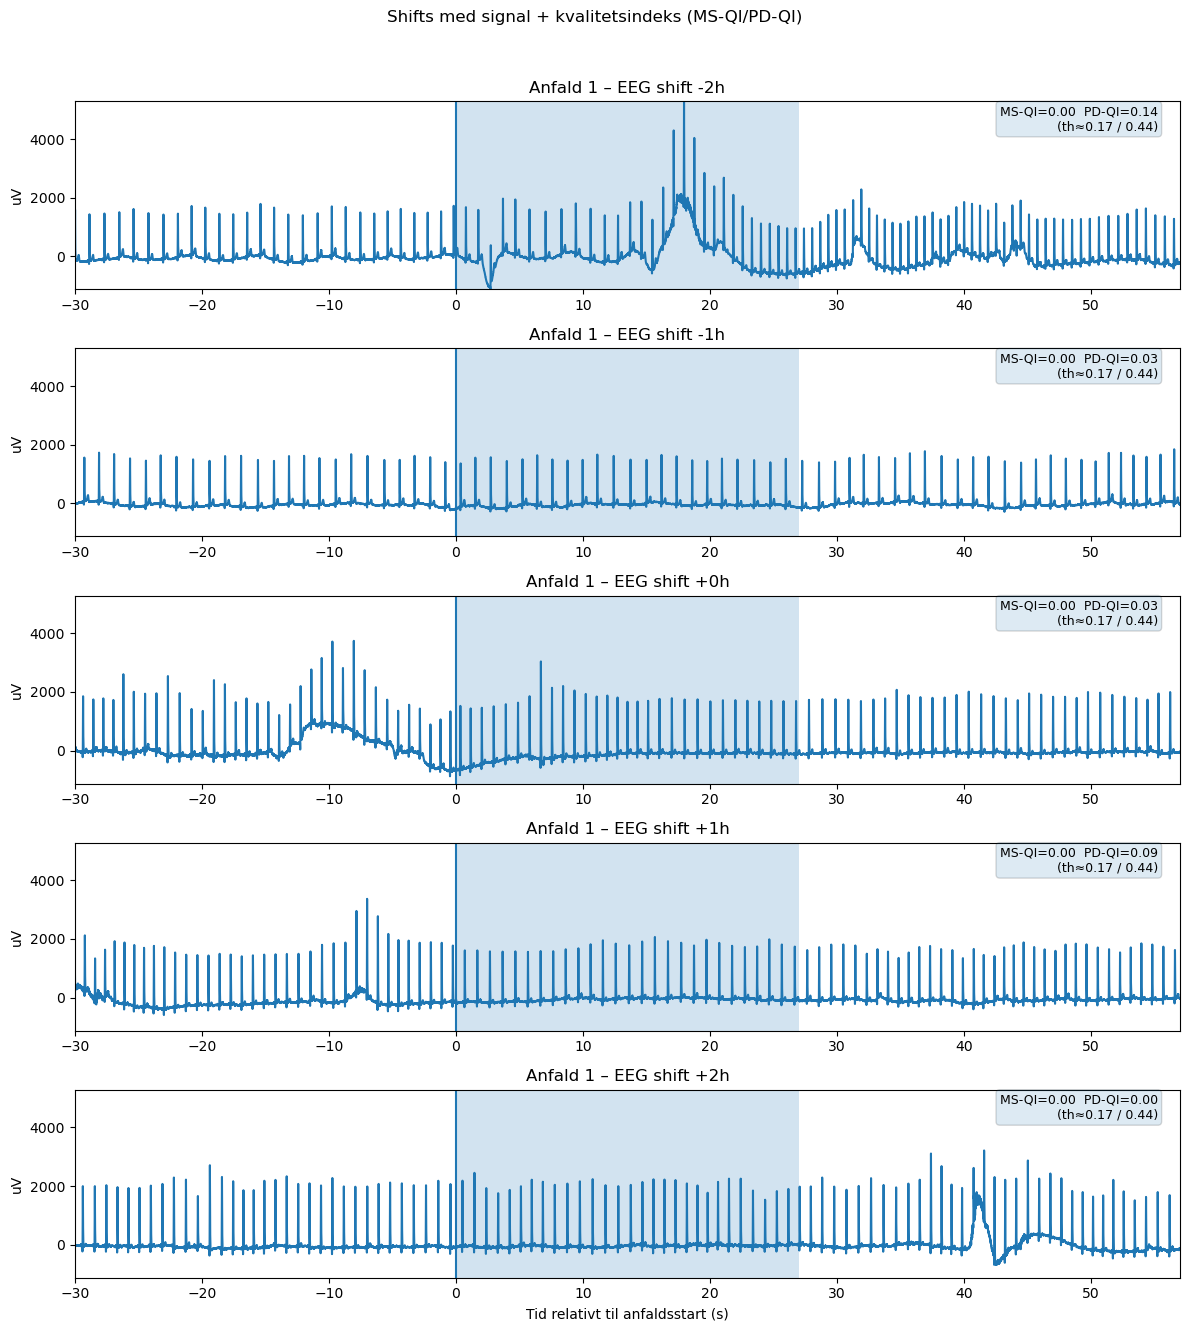

In [19]:
# Plot med QI overlejret:
plot_seizure_with_shifts_qi(sig, meta, ann_aligned,
                            seizure_id=1,
                            shifts_sec=(-7200,-3600,0,3600,7200))


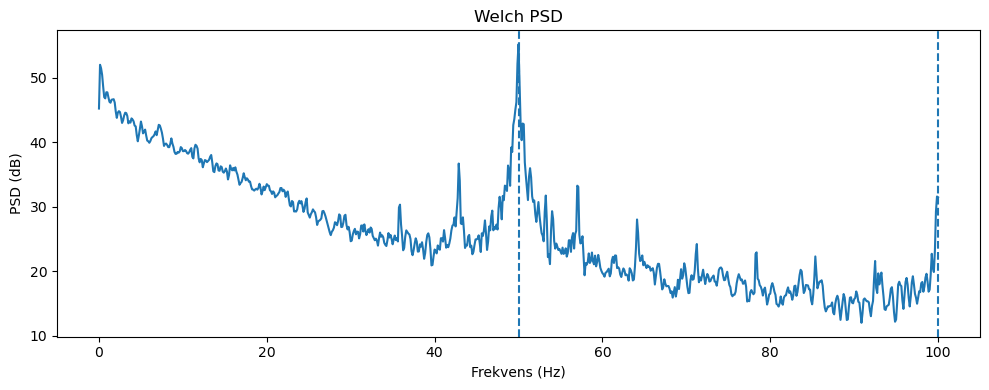

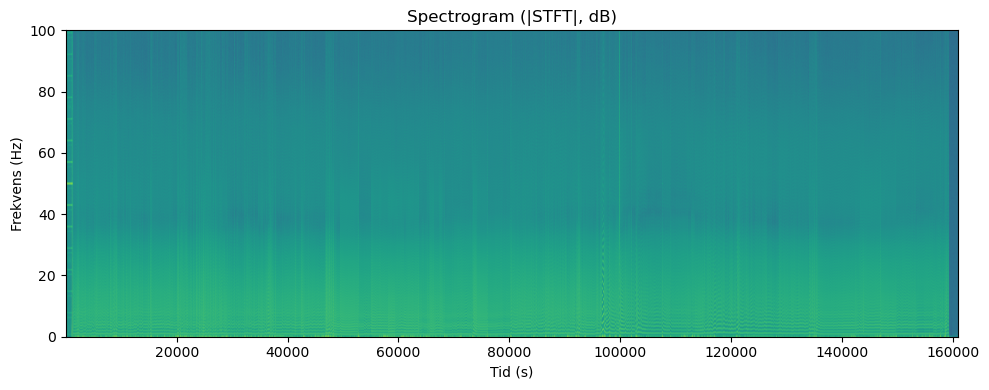

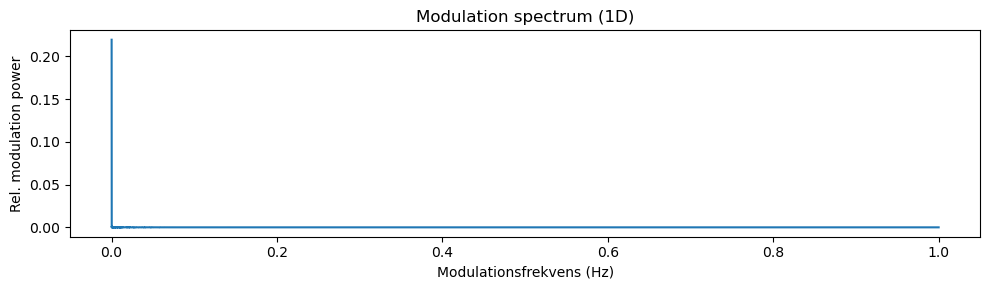

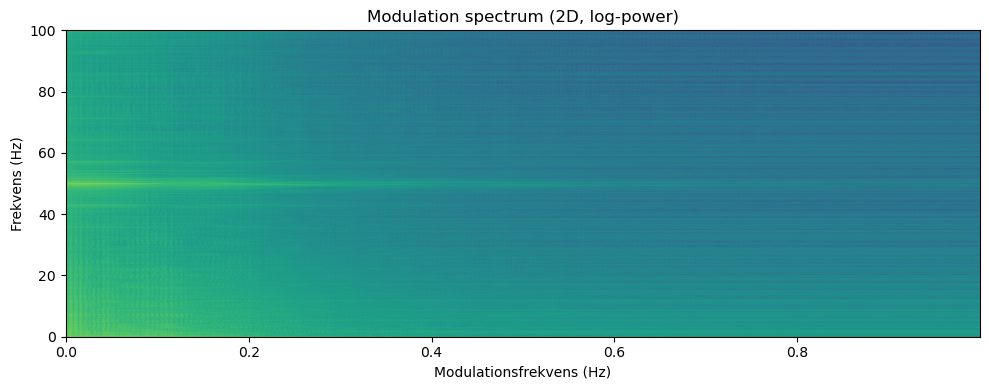

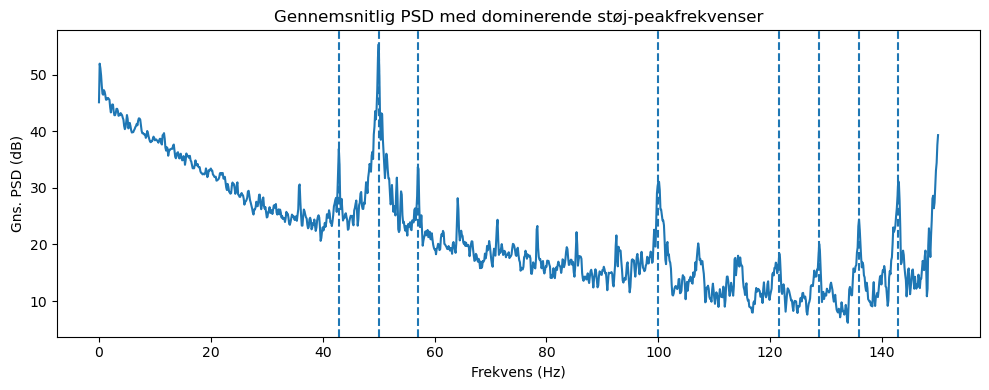

,freq_hz,level_db,prominence_db
0,50.000,55.351450,34.714545
1,142.875,31.200354,20.373299
2,100.000,31.080848,19.535126
3,135.875,24.396181,15.335145
4,42.875,36.882368,14.294465
5,128.750,20.113202,12.511836
6,57.000,33.676683,12.110964
7,121.625,18.396456,10.434776


In [20]:
from freq_tools import (
    plot_psd, summarize_psd_bands,
    plot_spectrogram,
    plot_modulation_spectrum_1d, plot_modulation_spectrum_2d,
    noise_fingerprint, compute_psd
)

# Antag sig, meta er dine data (meta.fs er fs)
# 1) PSD (med 50 Hz markører)
f, Pxx = plot_psd(sig, meta.fs, fmax=100.0, line_freq=50.0, harmonics=4)

# 2) Bandpower-resumé (relativ kraft pr. bånd)
bp = summarize_psd_bands(f, Pxx)
bp

# 3) Spectrogram (dB)
plot_spectrogram(sig, meta.fs, win_sec=4.0, hop_sec=0.25, fmax=100.0)

# 4) Modulationsspektrum (1D og 2D)
plot_modulation_spectrum_1d(sig, meta.fs, win_sec=8.0, hop_sec=0.5, fm_max=5.0)
plot_modulation_spectrum_2d(sig, meta.fs, win_sec=8.0, hop_sec=0.5, fm_max=5.0, fmax=100.0)

# 5) “Støjfingeraftryk” over hele optagelsen
peaks_df, (f_all, Pxx_mean) = noise_fingerprint(sig, meta.fs, window_sec=8.0, hop_sec=2.0,
                                                fmax=150.0, top_n=8, prominence_db=6.0)
peaks_df  # viser de dominerende frekvenser


In [21]:
from denoise_metrics import apply_notch_comb, noise_metrics, preservation_metrics
# (valgfrit) from denoise_metrics import rpeak_match_rate

# 1) Beregn “før”-metrikker
pre = noise_metrics(sig, meta.fs)

# 2) Filtrér: 50 Hz + harmoniske (fx op til 150 Hz)
sig_filt = apply_notch_comb(sig, meta.fs, line_freq=50.0, Q=30.0, harmonics=3)

# 3) “Efter”-metrikker
post = noise_metrics(sig_filt, meta.fs)

# 4) Signalbevarelse
pres = preservation_metrics(sig, sig_filt, meta.fs, lowpass_hz=40.0)

# 5) Saml i en rapportvenlig tabel
import pandas as pd
report = pd.DataFrame([{
    "rms_pre": pre["rms"], "rms_post": post["rms"],
    "line_ratio_pre": pre["line_noise_ratio"], "line_ratio_post": post["line_noise_ratio"],
    "hf_ratio_pre": pre["hf_noise_ratio"], "hf_ratio_post": post["hf_noise_ratio"],
    "snr_qrs_pre": pre["snr_qrs"], "snr_qrs_post": post["snr_qrs"],
    "lowband_corr": pres["lowband_corr"], "lowband_nrmse": pres["lowband_nrmse"]
}])

# 6) Beregn forbedringer (dB og forhold)
report["line_noise_reduction_dB"] = 10*np.log10((pre["line_noise_ratio"]+1e-20)/(post["line_noise_ratio"]+1e-20))
report["hf_noise_reduction_dB"]   = 10*np.log10((pre["hf_noise_ratio"]  +1e-20)/(post["hf_noise_ratio"]  +1e-20))
report["snr_qrs_improvement_dB"]  = 10*np.log10((post["snr_qrs"]       +1e-20)/(pre["snr_qrs"]         +1e-20))
report


,rms_pre,rms_post,line_ratio_pre,line_ratio_post,hf_ratio_pre,hf_ratio_post,snr_qrs_pre,snr_qrs_post,lowband_corr,lowband_nrmse,line_noise_reduction_dB,hf_noise_reduction_dB,snr_qrs_improvement_dB
0,669.873774,577.856841,0.921304,0.037805,1.015245,0.121087,0.348952,0.521066,0.997288,0.062833,13.868595,9.23472,1.74127


In [22]:
print("Pre bands:\n", pre["bands"])
print("Post bands:\n", post["bands"])


Pre bands:
     band  f_low  f_high          power  rel_power
0    ULF    0.0     0.5   58042.512443   0.134766
1    QRS    5.0    40.0  111412.489070   0.258684
2     HF   40.0   100.0  113110.964877   0.262627
3   Line   48.0    52.0  102644.823116   0.238326
4  Total    0.0   256.0  430690.015072   1.000000
Post bands:
     band  f_low  f_high          power  rel_power
0    ULF    0.0     0.5   58044.479729   0.178550
1    QRS    5.0    40.0  111364.463688   0.342566
2     HF   40.0   100.0   13484.829584   0.041480
3   Line   48.0    52.0    4210.079879   0.012951
4  Total    0.0   256.0  325088.844939   1.000000


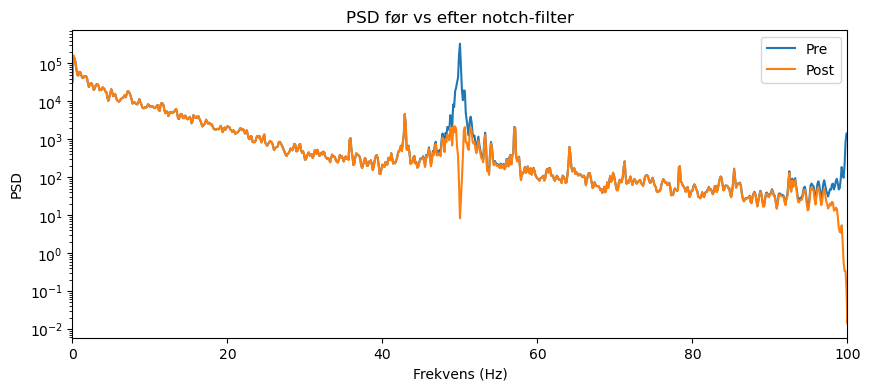

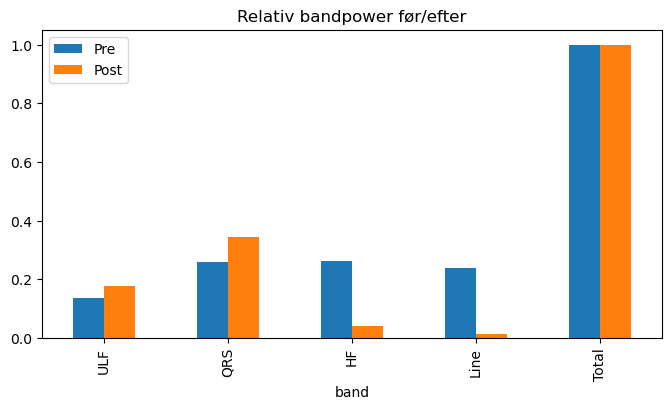

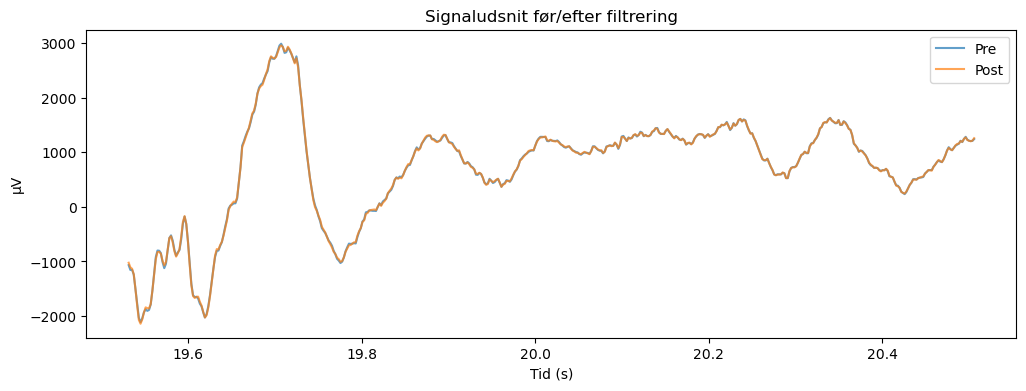

In [24]:
# 1) PSD før/efter
import matplotlib.pyplot as plt
f_pre, Pxx_pre = pre["psd"]
f_post, Pxx_post = post["psd"]

plt.figure(figsize=(10,4))
plt.semilogy(f_pre, Pxx_pre, label="Pre")
plt.semilogy(f_post, Pxx_post, label="Post")
plt.xlim(0,100); plt.xlabel("Frekvens (Hz)"); plt.ylabel("PSD")
plt.title("PSD før vs efter notch-filter")
plt.legend(); plt.show()

# 2) Barplot af bandpowers
bp_pre = pre["bands"].set_index("band")["rel_power"]
bp_post = post["bands"].set_index("band")["rel_power"]
df = pd.concat([bp_pre, bp_post], axis=1, keys=["Pre","Post"])
df.plot.bar(figsize=(8,4), title="Relativ bandpower før/efter")

# 3) Kort vindue i tidsdomænet
t = np.arange(len(sig))/meta.fs
plt.figure(figsize=(12,4))
win = slice(10000, 10500)  # vælg vindue i samples
plt.plot(t[win], sig[win], label="Pre", alpha=0.7)
plt.plot(t[win], sig_filt[win], label="Post", alpha=0.7)
plt.xlabel("Tid (s)"); plt.ylabel("µV")
plt.title("Signaludsnit før/efter filtrering")
plt.legend(); plt.show()


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== (A) R-peak detektor (fallback) ====
# Brug gerne din egen/det vi lavede til CSI, hvis du allerede har den importeret.
from scipy.signal import butter, filtfilt, find_peaks

def _bandpass_simple(x, fs, low=5.0, high=20.0, order=2):
    nyq = fs/2
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, x)

def detect_r_peaks_fallback(ecg, fs, prom_factor=4.0, distance_ms=250):
    x = _bandpass_simple(ecg, fs)
    env = np.abs(x)
    win = int(fs*0.1) or 1
    env_smooth = np.convolve(env, np.ones(win)/win, mode="same")
    prom = np.median(env_smooth) * prom_factor
    peaks, _ = find_peaks(env_smooth, prominence=prom, distance=int(fs*distance_ms/1000))
    return peaks

# ==== (B) R-peak match (fra denoise_metrics.py hvis du har den – ellers her) ====
def rpeak_match_rate(peaks_pre, peaks_post, fs, tol_ms=40):
    if len(peaks_pre) == 0 or len(peaks_post) == 0:
        return np.nan
    tol = int(tol_ms * fs / 1000.0)
    j = 0; hits = 0
    for i in peaks_pre:
        while j < len(peaks_post) and peaks_post[j] < i - tol:
            j += 1
        if j < len(peaks_post) and abs(peaks_post[j] - i) <= tol:
            hits += 1; j += 1
    return float(hits / max(len(peaks_pre), 1))

# ==== (C) PSD-plot før/efter ====
def plot_psd_pre_post(pre, post, fmax=100.0, title="PSD før/efter"):
    f_pre, Pxx_pre = pre["psd"]
    f_post, Pxx_post = post["psd"]
    plt.figure(figsize=(10,4))
    plt.semilogy(f_pre, Pxx_pre, label="Pre")
    plt.semilogy(f_post, Pxx_post, label="Post")
    plt.xlim(0, fmax)
    plt.xlabel("Frekvens (Hz)"); plt.ylabel("PSD")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==== (D) Bandpower-barplot ====
def plot_bandpower_bars(pre, post, title="Relativ bandpower pr. bånd (Pre vs Post)"):
    bp_pre = pre["bands"].set_index("band")["rel_power"]
    bp_post = post["bands"].set_index("band")["rel_power"]
    df = pd.concat([bp_pre, bp_post], axis=1, keys=["Pre","Post"]).loc[["ULF","QRS","HF","Line"]]
    ax = df.plot.bar(figsize=(8,4), title=title)
    ax.set_xlabel("Bånd"); ax.set_ylabel("Relativ power")
    plt.tight_layout(); plt.show()

# ==== (E) Tidsdomæne-vindue + R-peaks ====
def plot_time_window_with_rpeaks(sig_pre, sig_post, fs, t0_sec, t1_sec,
                                 use_fallback_detector=True,
                                 prom_factor=4.0, distance_ms=250):
    i0 = max(0, int(t0_sec*fs)); i1 = min(len(sig_pre), int(t1_sec*fs))
    t = np.arange(i0, i1)/fs

    # vælg detektor
    det = detect_r_peaks_fallback if use_fallback_detector else detect_r_peaks  # hvis du har din egen importeret

    # detect r-peaks i hele signalet (stabil timing), men plot kun i vindue
    p_pre  = det(sig_pre, fs, prom_factor=prom_factor, distance_ms=distance_ms)
    p_post = det(sig_post, fs, prom_factor=prom_factor, distance_ms=distance_ms)
    m_pre  = (p_pre>=i0) & (p_pre<i1)
    m_post = (p_post>=i0) & (p_post<i1)

    plt.figure(figsize=(12,4))
    plt.plot(t, sig_pre[i0:i1], label="Pre", alpha=0.6)
    plt.plot(t, sig_post[i0:i1], label="Post", alpha=0.8)
    plt.scatter(p_pre[m_pre]/fs, sig_pre[p_pre[m_pre]], s=20, marker="o", label="R peaks (Pre)")
    plt.scatter(p_post[m_post]/fs, sig_post[p_post[m_post]], s=20, marker="x", label="R peaks (Post)")
    plt.xlabel("Tid (s)"); plt.ylabel("Amplitude")
    plt.title(f"Tidsvindue {t0_sec:.2f}–{t1_sec:.2f} s med R-peak overlay")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # match rate på hele signalet
    match = rpeak_match_rate(p_pre, p_post, fs, tol_ms=40)
    return {"peaks_pre": p_pre, "peaks_post": p_post, "match_rate": match}

# ==== (F) Dashboard: samlet figur ====
def plot_denoise_dashboard(sig_pre, sig_post, fs, pre_metrics, post_metrics,
                           t0_sec, t1_sec, title="Denoise Dashboard"):
    # 1x3: PSD, bandpowers, tidsvindue + peaks. Tekstboks med metrics i tidsvindue-aksen.
    f_pre, Pxx_pre = pre_metrics["psd"]
    f_post, Pxx_post = post_metrics["psd"]

    # bandpowers
    bp_pre = pre_metrics["bands"].set_index("band")["rel_power"]
    bp_post = post_metrics["bands"].set_index("band")["rel_power"]
    bands_df = pd.concat([bp_pre, bp_post], axis=1, keys=["Pre","Post"]).loc[["ULF","QRS","HF","Line"]]

    # tidsvindue
    i0 = max(0, int(t0_sec*fs)); i1 = min(len(sig_pre), int(t1_sec*fs))
    t = np.arange(i0, i1)/fs

    # peaks (brug fallback detektor)
    p_pre  = detect_r_peaks_fallback(sig_pre, fs)
    p_post = detect_r_peaks_fallback(sig_post, fs)
    m_pre  = (p_pre>=i0) & (p_pre<i1)
    m_post = (p_post>=i0) & (p_post<i1)
    match_rate = rpeak_match_rate(p_pre, p_post, fs, tol_ms=40)

    # forbedrings-tal
    line_red_db = 10*np.log10((pre_metrics["line_noise_ratio"]+1e-20)/(post_metrics["line_noise_ratio"]+1e-20))
    hf_red_db   = 10*np.log10((pre_metrics["hf_noise_ratio"]  +1e-20)/(post_metrics["hf_noise_ratio"]  +1e-20))
    snr_imp_db  = 10*np.log10((post_metrics["snr_qrs"]        +1e-20)/(pre_metrics["snr_qrs"]          +1e-20))

    fig = plt.figure(figsize=(15,4.5))
    fig.suptitle(title)

    # Ax1: PSD
    ax1 = fig.add_subplot(1,3,1)
    ax1.semilogy(f_pre,  Pxx_pre,  label="Pre")
    ax1.semilogy(f_post, Pxx_post, label="Post")
    ax1.set_xlim(0, 100.0)
    ax1.set_xlabel("Frekvens (Hz)"); ax1.set_ylabel("PSD")
    ax1.set_title("PSD (Welch)")
    ax1.legend()

    # Ax2: bandpowers
    ax2 = fig.add_subplot(1,3,2)
    x = np.arange(len(bands_df))
    w = 0.38
    ax2.bar(x - w/2, bands_df["Pre"].values, width=w, label="Pre")
    ax2.bar(x + w/2, bands_df["Post"].values, width=w, label="Post")
    ax2.set_xticks(x); ax2.set_xticklabels(bands_df.index)
    ax2.set_ylim(0, 1.0)
    ax2.set_ylabel("Relativ power")
    ax2.set_title("Bandpower (rel.)")
    ax2.legend()

    # Ax3: tidsvindue + peaks
    ax3 = fig.add_subplot(1,3,3)
    ax3.plot(t, sig_pre[i0:i1],  label="Pre",  alpha=0.6)
    ax3.plot(t, sig_post[i0:i1], label="Post", alpha=0.8)
    ax3.scatter(p_pre[m_pre]/fs,  sig_pre[p_pre[m_pre]],   s=16, marker="o", label="R peaks (Pre)")
    ax3.scatter(p_post[m_post]/fs, sig_post[p_post[m_post]], s=16, marker="x", label="R peaks (Post)")
    ax3.set_xlabel("Tid (s)"); ax3.set_ylabel("Amplitude")
    ax3.set_title(f"Tidsvindue {t0_sec:.1f}–{t1_sec:.1f} s")
    ax3.legend(loc="lower left")

    # Tekstboks med nøglemetrikker
    text = (f"line_ratio: {pre_metrics['line_noise_ratio']:.3f} → {post_metrics['line_noise_ratio']:.3f}  "
            f"({line_red_db:.2f} dB)\n"
            f"hf_ratio:   {pre_metrics['hf_noise_ratio']:.3f} → {post_metrics['hf_noise_ratio']:.3f}  "
            f"({hf_red_db:.2f} dB)\n"
            f"SNR(QRS):   {pre_metrics['snr_qrs']:.3f} → {post_metrics['snr_qrs']:.3f}  "
            f"(+{snr_imp_db:.2f} dB)\n"
            f"R-peak match: {match_rate*100:.1f}%")
    ax3.text(0.98, 0.98, text, transform=ax3.transAxes, va="top", ha="right",
             bbox=dict(boxstyle="round", alpha=0.15, pad=0.4), fontsize=9)

    plt.tight_layout()
    plt.show()


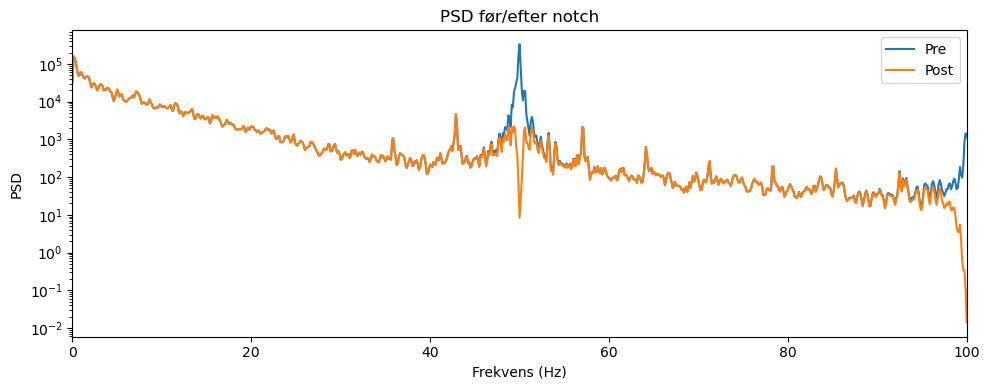

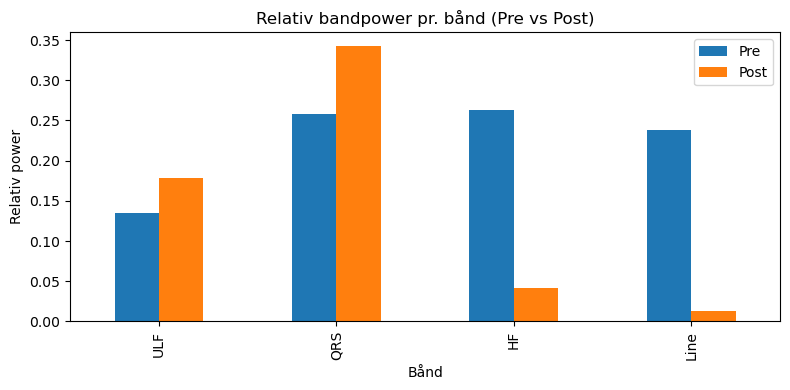

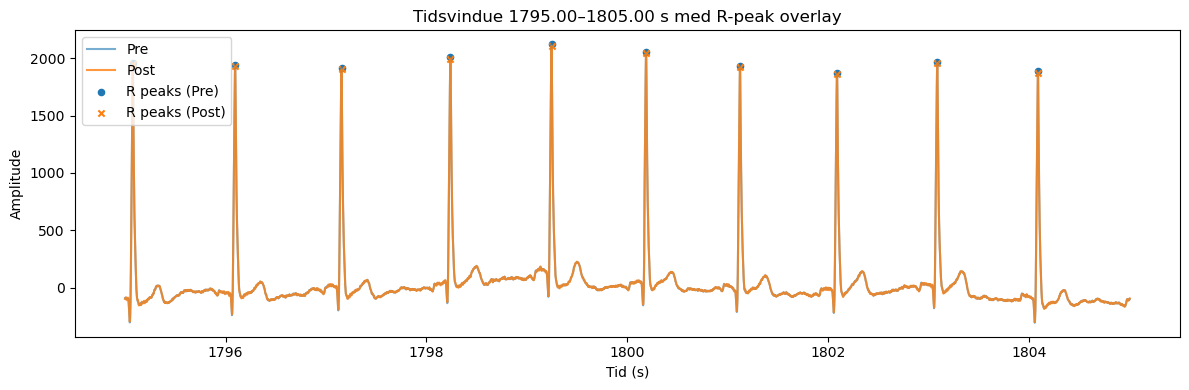

R-peak match-rate (hele signalet): 100.0%


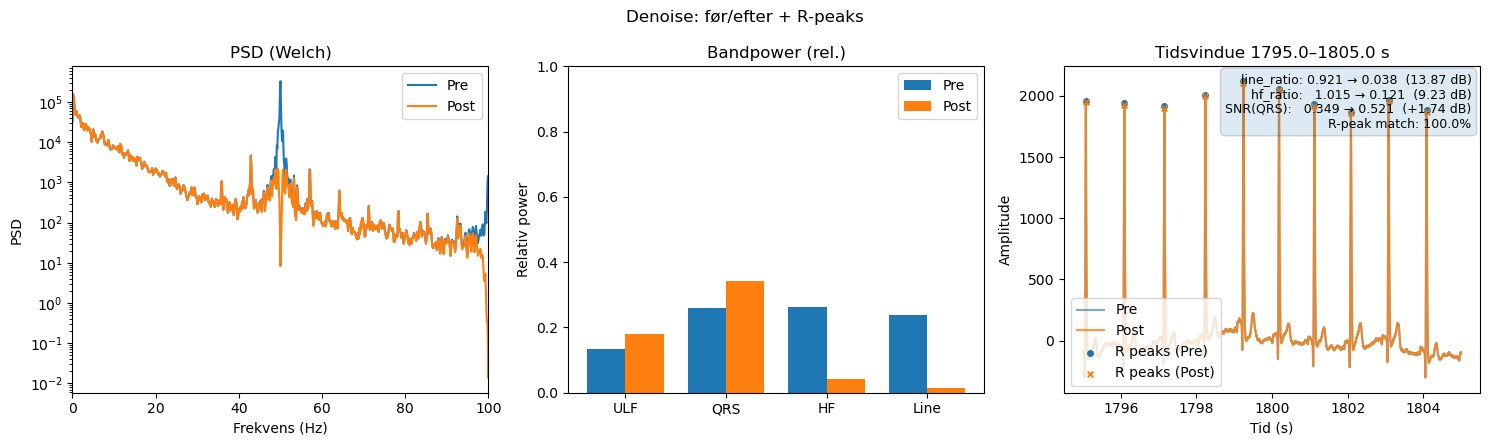

In [26]:
# 0) Du har allerede:
# sig, sig_filt, meta.fs
# pre = noise_metrics(sig, meta.fs)
# post = noise_metrics(sig_filt, meta.fs)

# 1) PSD og bandpowers:
plot_psd_pre_post(pre, post, fmax=100.0, title="PSD før/efter notch")
plot_bandpower_bars(pre, post, title="Relativ bandpower pr. bånd (Pre vs Post)")

# 2) Vælg et tidsvindue (fx 10 sek) til visuel sammenligning:
center_sec = 60*30          # fx 30 minutter inde (tilpas)
half_win   = 5              # 5 sek på hver side
t0, t1 = center_sec - half_win, center_sec + half_win

rpk = plot_time_window_with_rpeaks(sig, sig_filt, meta.fs, t0, t1,
                                   use_fallback_detector=True,
                                   prom_factor=4.0, distance_ms=250)
print("R-peak match-rate (hele signalet):", f"{rpk['match_rate']*100:.1f}%")

# 3) “Dashboard” der samler PSD, bandpowers, tidsvindue og nøgletal:
plot_denoise_dashboard(sig, sig_filt, meta.fs, pre, post, t0, t1,
                       title="Denoise: før/efter + R-peaks")


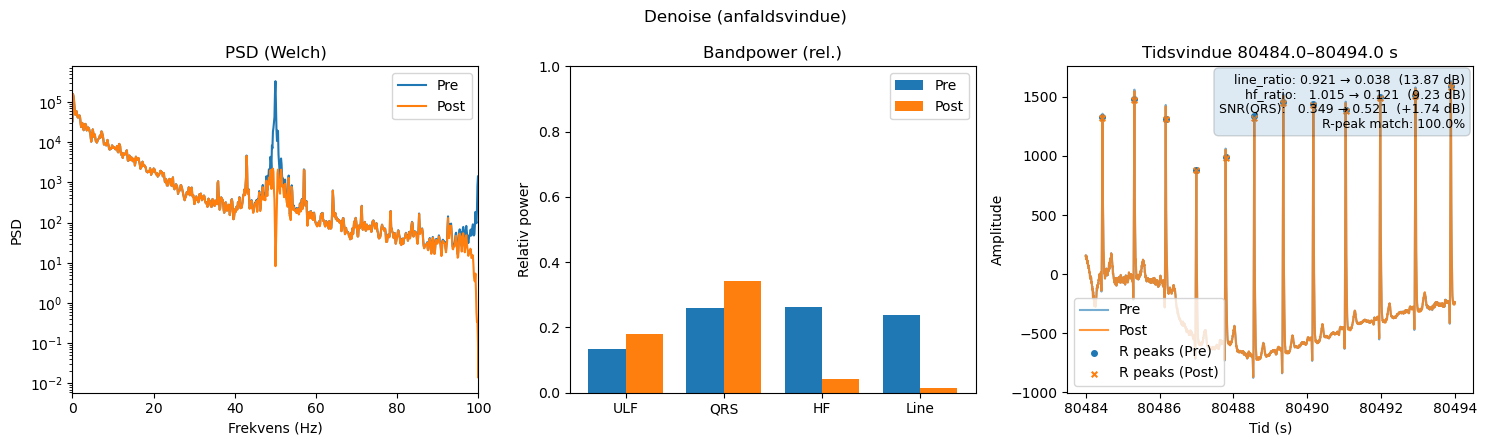

In [27]:
# antag ann_aligned og seizure_id
row = ann_aligned[ann_aligned["seizure_id"]==1].iloc[0]
onset_idx = int(row.get("eeg_onset_idx") or row.get("klin_onset_idx"))
center_sec = onset_idx / meta.fs
t0, t1 = center_sec - 5, center_sec + 5

plot_denoise_dashboard(sig, sig_filt, meta.fs, pre, post, t0, t1,
                       title="Denoise (anfaldsvindue)")
